# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import os
import joblib

# Carga de datos

In [2]:
df= pd.read_csv(r'C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\Datasets\team_stats.csv')

# Predicción de los datos históricos

## Prueba Dickey-Fuller (estacionariedad)

La prueba Adf_team_stats_team_stats tiene como objetivo rechazar la hipótesis nula de que los datos de la serie temporal dada no son estacionarios. Calcula el valor $p$ y lo compara con un valor umbral o nivel de significación de 0.05. Si el valor p es menor que este nivel, entonces los datos son estacionarios; de lo contrario, el orden de diferenciación se incrementa en uno.

Hipótesis Nula (H0): La serie es no estacionaria. Esta hipótesis sugiere que la serie sigue un proceso estocástico, lo que implica que hay una tendencia o un comportamiento no constante en el tiempo.

Hipótesis Alternativa (H1): La serie es estacionaria. Esta hipótesis sugiere que la serie temporal es estacionaria o que cualquier tendencia en los datos ha sido eliminada mediante la diferenciación.

El obtetivo del test es la aplicación del modelo ARIMA para predecir el total de victorias durante la fase regular

In [3]:
def test_stationarity(df_team):

    #Seleccionamos la posición de los equipos a lo largo de las temporadas
    serie = df_team['W']

    #Realizamos la prueba ADF e interpretamos el resultado
    result = adfuller(serie)
    
    print(f'\nEquipo analizado: {df_team["Team"].iloc[0]}')
    print(f'p-value: {result[1]}')
    
    if result[1] < 0.05:
        print("La serie temporal es estacionaria (rechazamos la hipótesis nula).")
        return

    print("La serie temporal no es estacionaria (no podemos rechazar la hipótesis nula), se aplicará primera diferenciación")

    #Aplicamos la primera diferenciación y realizamos nuevamente la prueba ADF en la serie diferenciada por primera vez
    
    serie_diff1 = serie.diff().dropna()
    result_diff1 = adfuller(serie_diff1)
   
    print(f'p-value (1ra Diferenciada): {result_diff1[1]}')
    
    if result_diff1[1] < 0.05:
        print("La serie diferenciada (1ra) es estacionaria (rechazamos la hipótesis nula).")
        return

    print("La serie diferenciada (1ra) no es estacionaria (no podemos rechazar la hipótesis nula), se aplicará segunda diferenciación.")

    #Aplicamos la segunda diferenciación y realizamos nuevamente la prueba ADF en la serie diferenciada por primera vez
    
    serie_diff2 = serie_diff1.diff().dropna()   
    result_diff2 = adfuller(serie_diff2)
    
    print(f'p-value (2da Diferenciada): {result_diff2[1]}')
    
    if result_diff2[1] < 0.05:
        print("La serie diferenciada (2da) es estacionaria (rechazamos la hipótesis nula).")
        return

    print("La serie diferenciada (2da) no es estacionaria (no podemos rechazar la hipótesis nula), se aplicará tercera diferenciación.")

    #Aplicamos la tercera diferenciación y realizamos nuevamente la prueba ADF en la serie diferenciada por primera vez

    serie_diff3 = serie_diff2.diff().dropna() 
    result_diff3 = adfuller(serie_diff3)
    
    print(f'p-value (3ra Diferenciada): {result_diff3[1]}')
    
    if result_diff3[1] < 0.05:
        print("La serie diferenciada (3ra diferencia) es estacionaria (rechazamos la hipótesis nula).")
    else:
        print("La serie diferenciada (3ra diferencia) no es estacionaria (no podemos rechazar la hipótesis nula).")

#Aplicamos el test para cada equipo
equipos = df['Team'].unique()

for equipo in equipos:
    df_team = df[df['Team'] == equipo]
    test_stationarity(df_team)


Equipo analizado: ATL
p-value: 0.007349701395879216
La serie temporal es estacionaria (rechazamos la hipótesis nula).

Equipo analizado: BOS
p-value: 0.14433550870470202
La serie temporal no es estacionaria (no podemos rechazar la hipótesis nula), se aplicará primera diferenciación
p-value (1ra Diferenciada): 2.700570956523982e-15
La serie diferenciada (1ra) es estacionaria (rechazamos la hipótesis nula).

Equipo analizado: BRK
p-value: 2.2370430098958707e-05
La serie temporal es estacionaria (rechazamos la hipótesis nula).

Equipo analizado: CHA
p-value: 0.0018322103650920223
La serie temporal es estacionaria (rechazamos la hipótesis nula).

Equipo analizado: CHI
p-value: 0.04232526110798147
La serie temporal es estacionaria (rechazamos la hipótesis nula).

Equipo analizado: CLE
p-value: 0.020610582179255526
La serie temporal es estacionaria (rechazamos la hipótesis nula).

Equipo analizado: DAL
p-value: 0.2237159287751206
La serie temporal no es estacionaria (no podemos rechazar la 

La diferenciación ha funcionado para todos los equipos excepto NOH, que no hemos conseguido que sea estacionario, pero seguiremos con el modelo ya que sólo afecta a un equipo

## Modelo ARIMA

In [4]:
#Lista de diferenciaciones calculados en la fase anterior
d_values = {
    'ATL': 0, 'BOS': 1, 'BRK': 0, 'CHA': 0, 'CHI': 0, 'CLE': 0, 'DAL': 1, 'DEN': 0, 'DET': 1, 'GSW': 0,
    'HOU': 0, 'IND': 1, 'LAC': 0, 'LAL': 1, 'MEM': 1, 'MIA': 0, 'MIL': 1, 'MIN': 0, 'NOH': 3, 'NYK': 0,
    'OKC': 0, 'ORL': 1, 'PHI': 1, 'PHO': 0, 'POR': 0, 'SAC': 1, 'SAS': 0, 'TOR': 1, 'UTA': 0, 'WAS': 0}

#Almacenamos los modelos ajustados, parámetros (p, d, q) y las series temporales
models = {}
params = {}
series_data = {}

for equipo, d in d_values.items():
    df_team = df[df['Team'] == equipo].copy()
    
    #Establecemos'Season' como ínidce y en formato fecha
    df_team['Season'] = pd.to_datetime(df_team['Season'], format='%Y')
    series = df_team.set_index('Season')['W']
    
    #Modelo ARIMA
    model = auto_arima(
        series,
        start_p=1,
        start_q=1,
        max_p=5,
        max_q=5,
        m=1,
        d=d,
        seasonal=False,
        D=None,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True)
    
    model_fit = model.fit(series)
    models[equipo] = model_fit
    
    #Extraemos los parámetros p, d, q del mejor modelo y lo almacenamos como diccionario
    p = model_fit.order[0]
    d = model_fit.order[1]
    q = model_fit.order[2]
    
    params[equipo] = {'p': p, 'd': d, 'q': q}
    
    #Almacenamos la serie temporal en el diccionario
    series_data[equipo] = series
    
    #Imprimimos los resultados
    print(f"Equipo: {equipo}")
    print(f"Parámetros del modelo ARIMA - p: {p}, d: {d}, q: {q}")
    print("Lista de parámetros ARIMA por equipo:")
for equipo, param in params.items():
    print(f"{equipo}: {param}")

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=341.786, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=464.704, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=341.899, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=423.086, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=341.409, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=392.074, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=345.677, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=339.100, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=385.878, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=339.620, Time=0.11 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=341.100, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=370.095, Time=0.20 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=341.591, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=334.468, 

## Graficamos los resultados

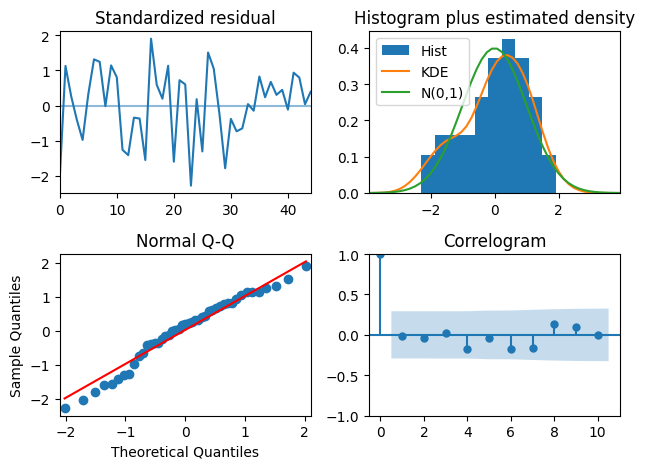

In [5]:
#Mostramos resultados
model_fit.plot_diagnostics()
plt.tight_layout()
plt.show()

## Comparamos los resultados reales de la serie temporal y con el modelo de predicción

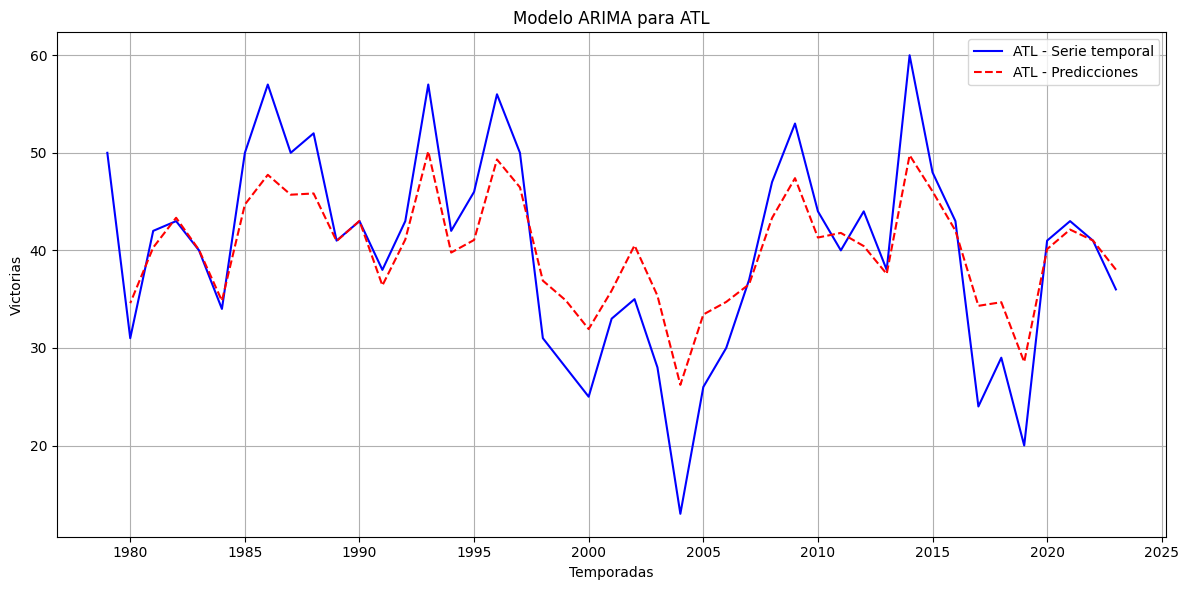

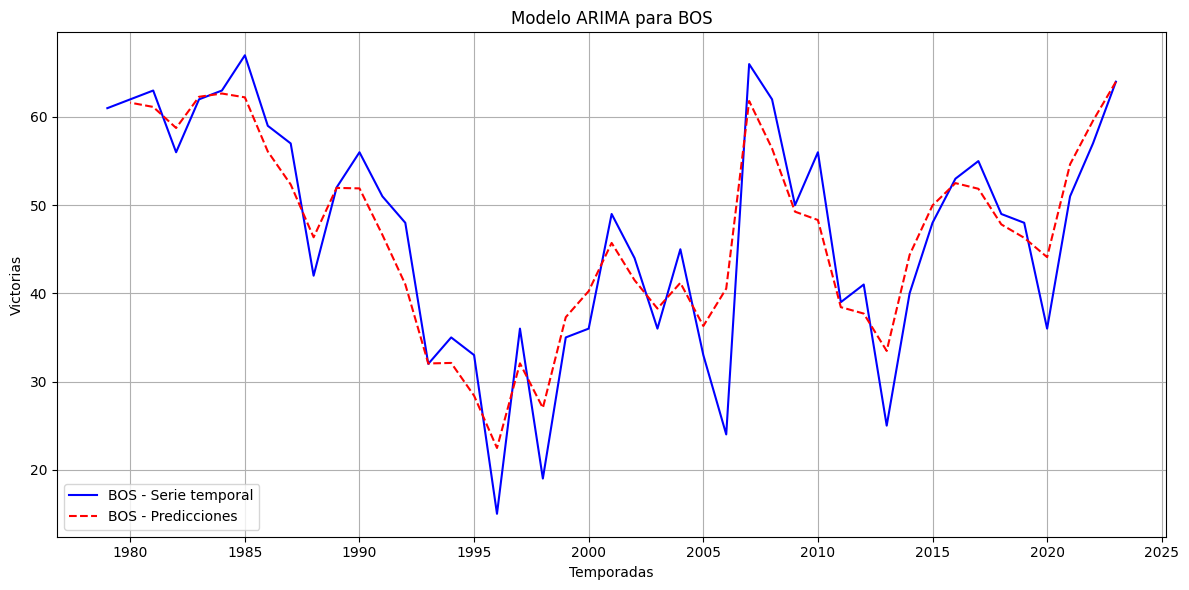

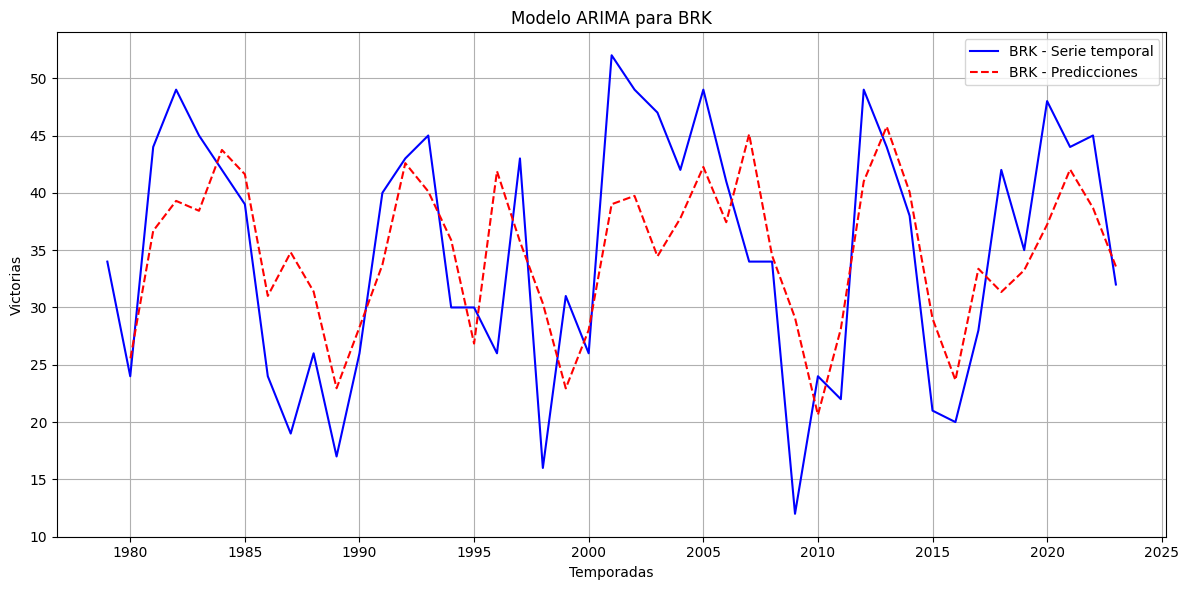

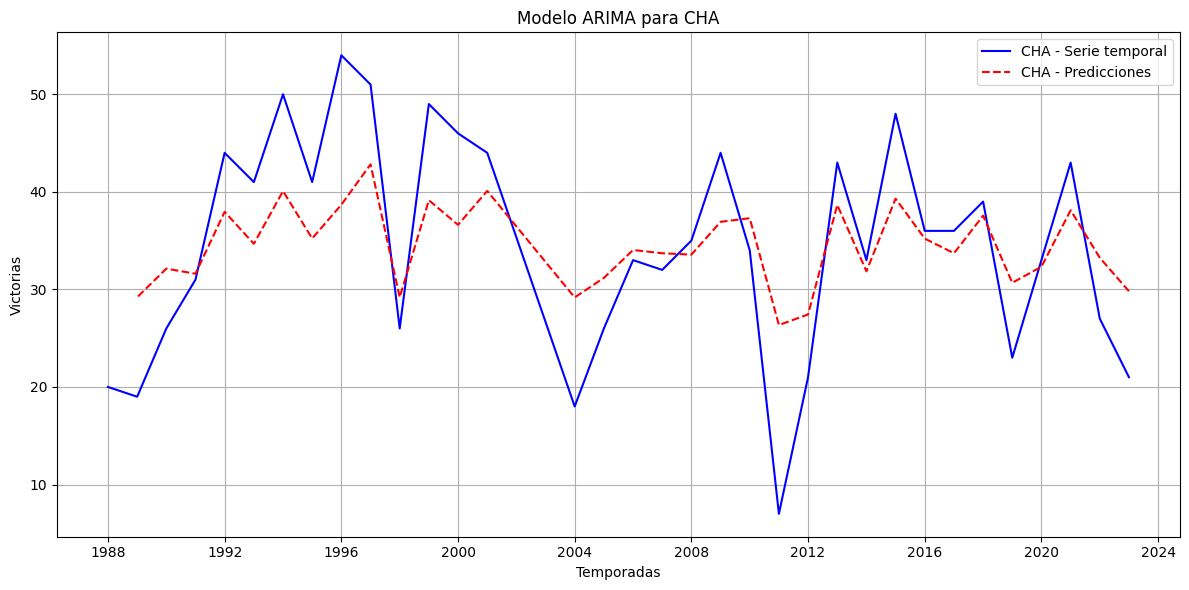

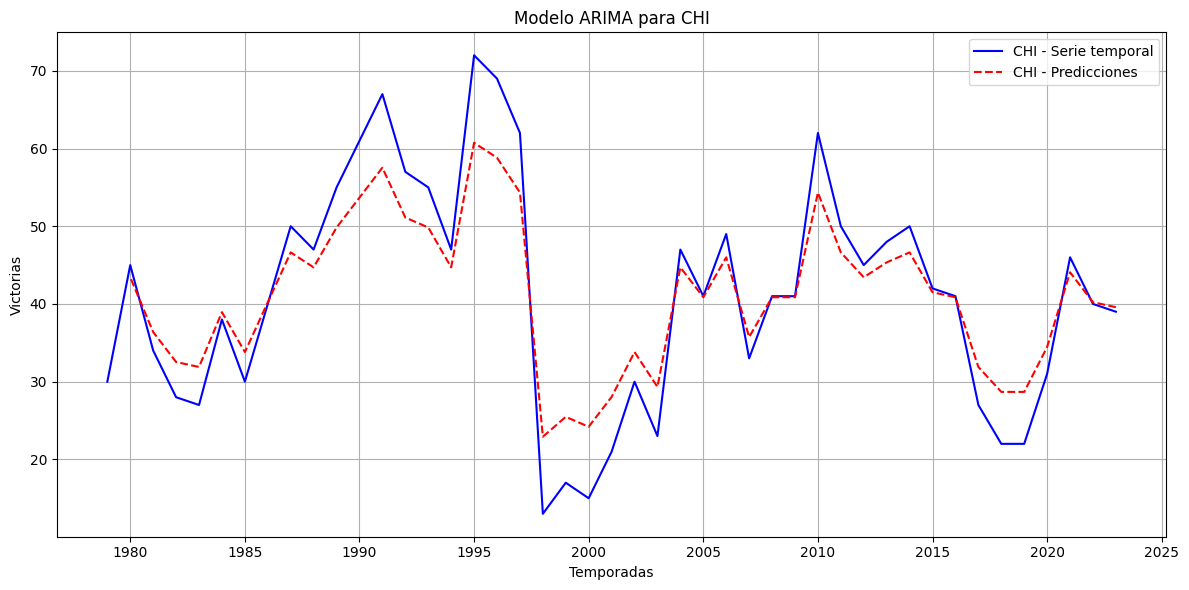

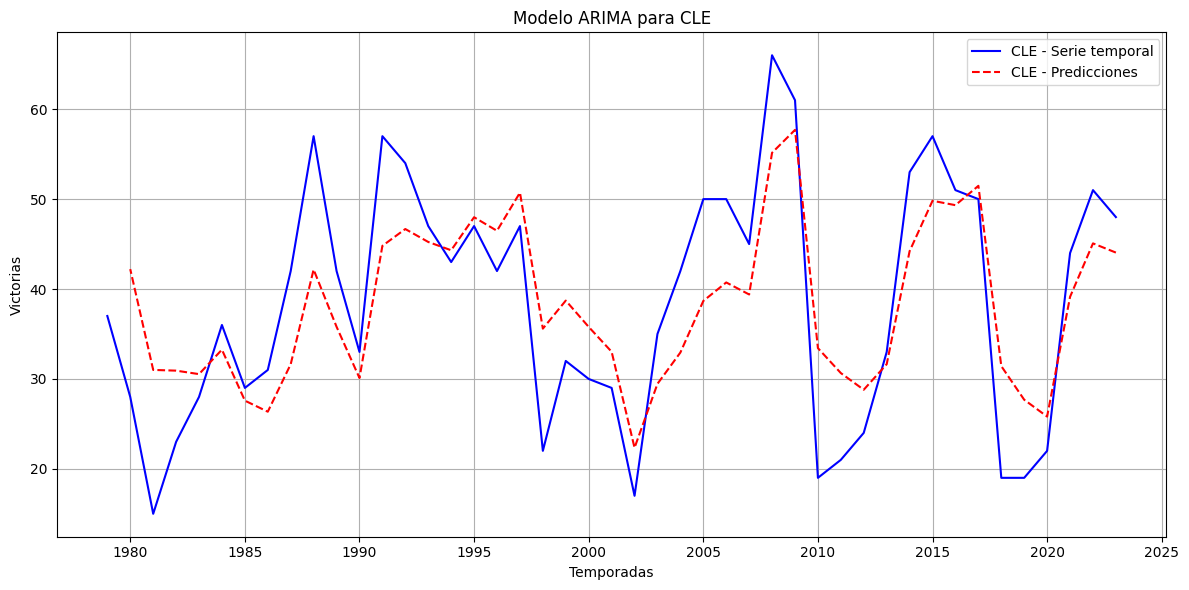

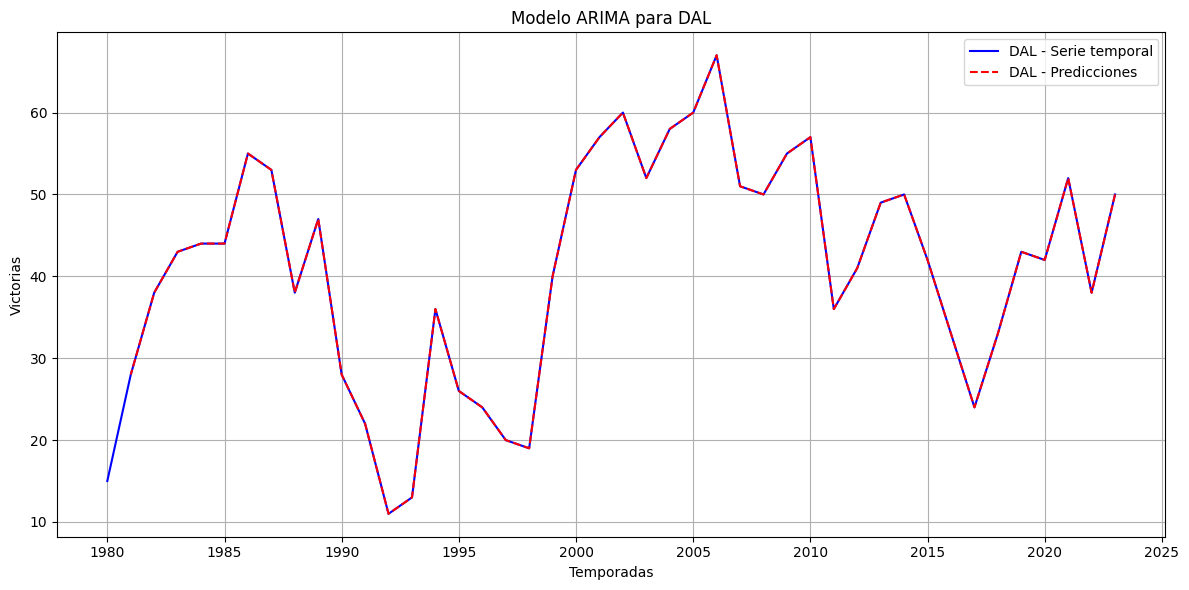

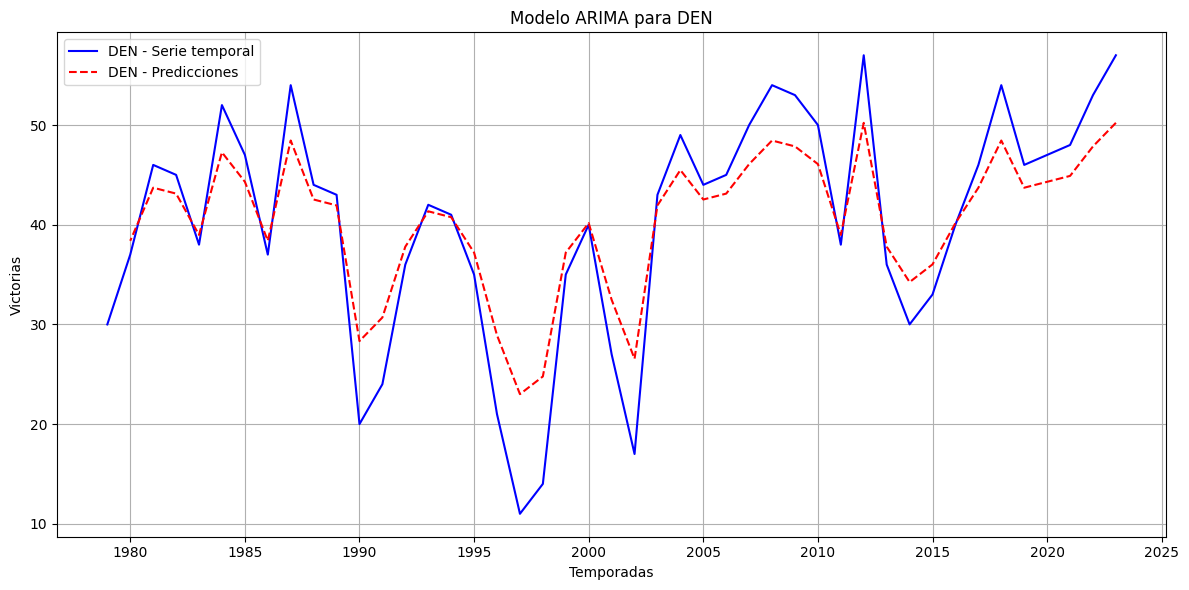

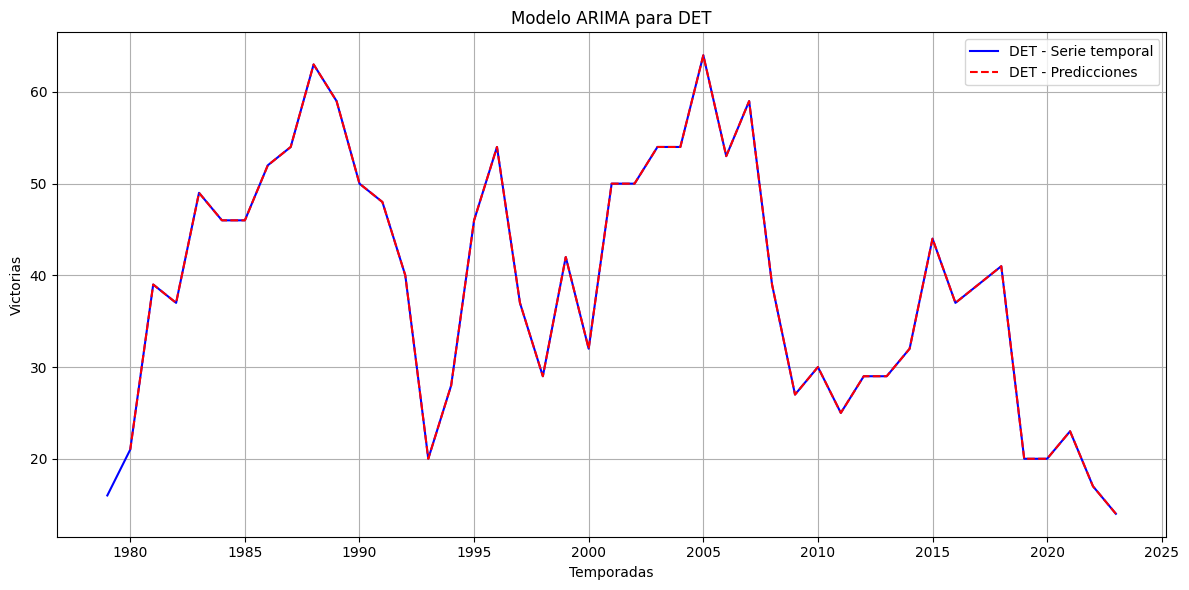

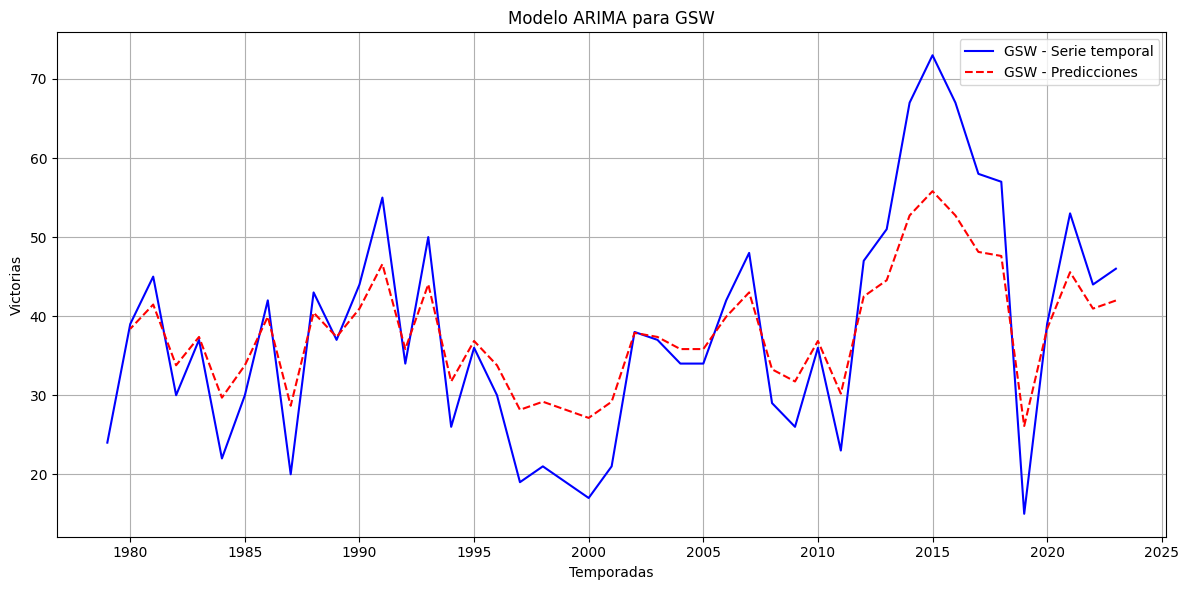

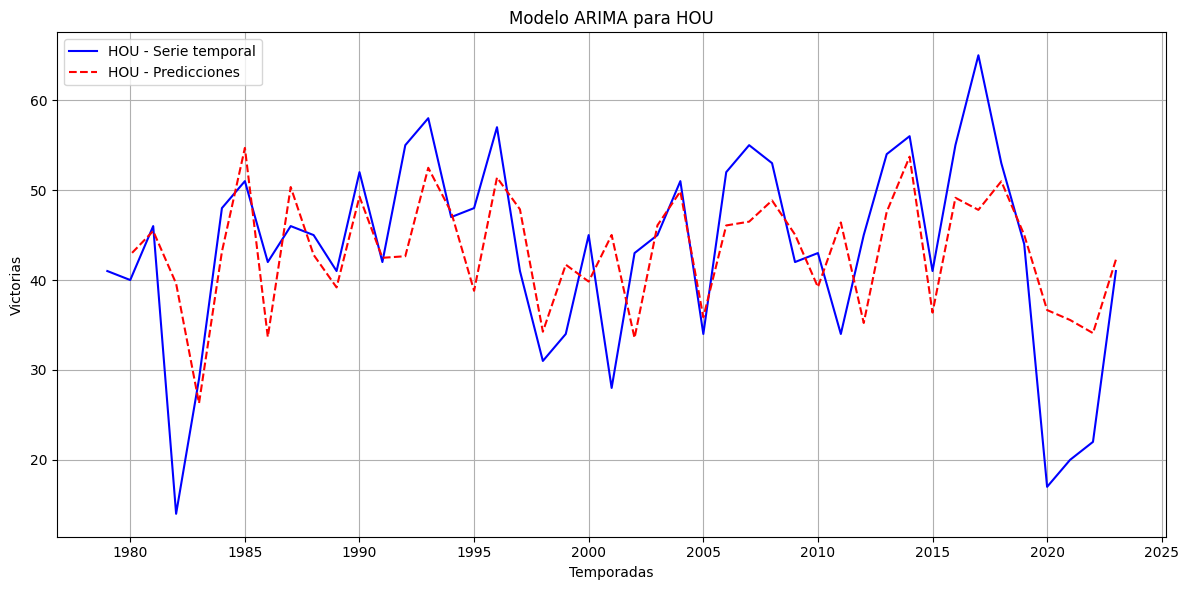

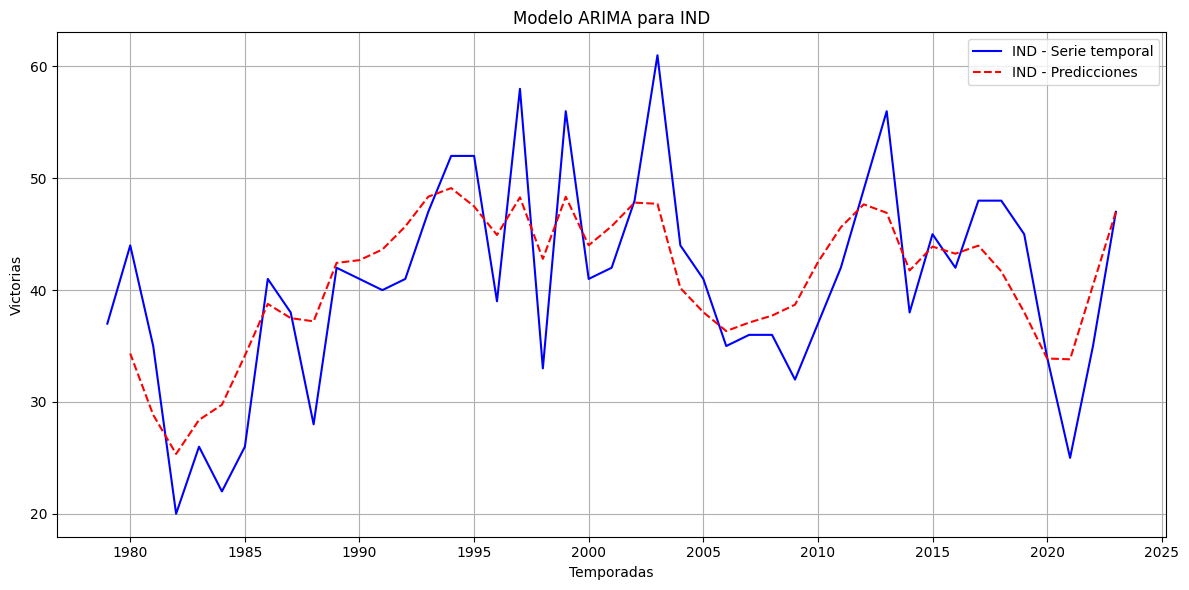

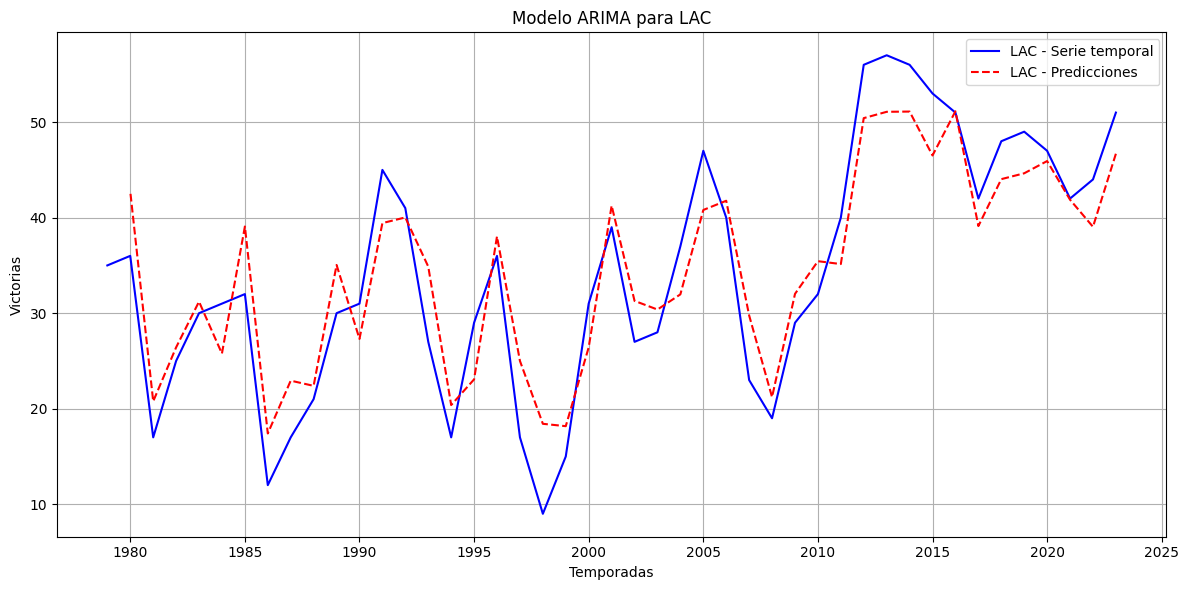

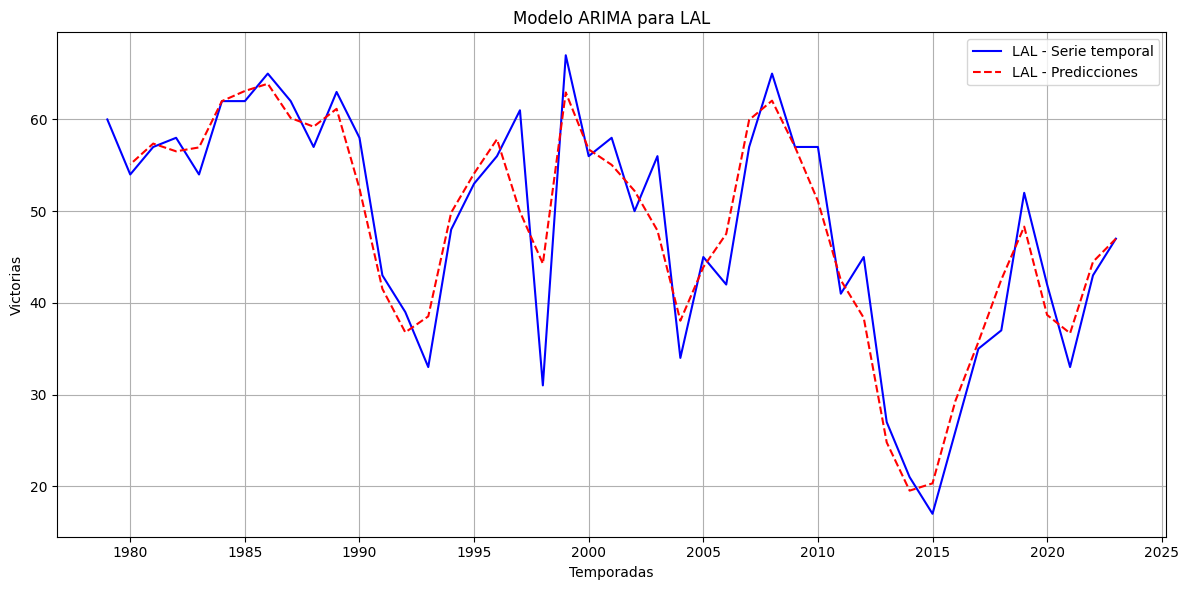

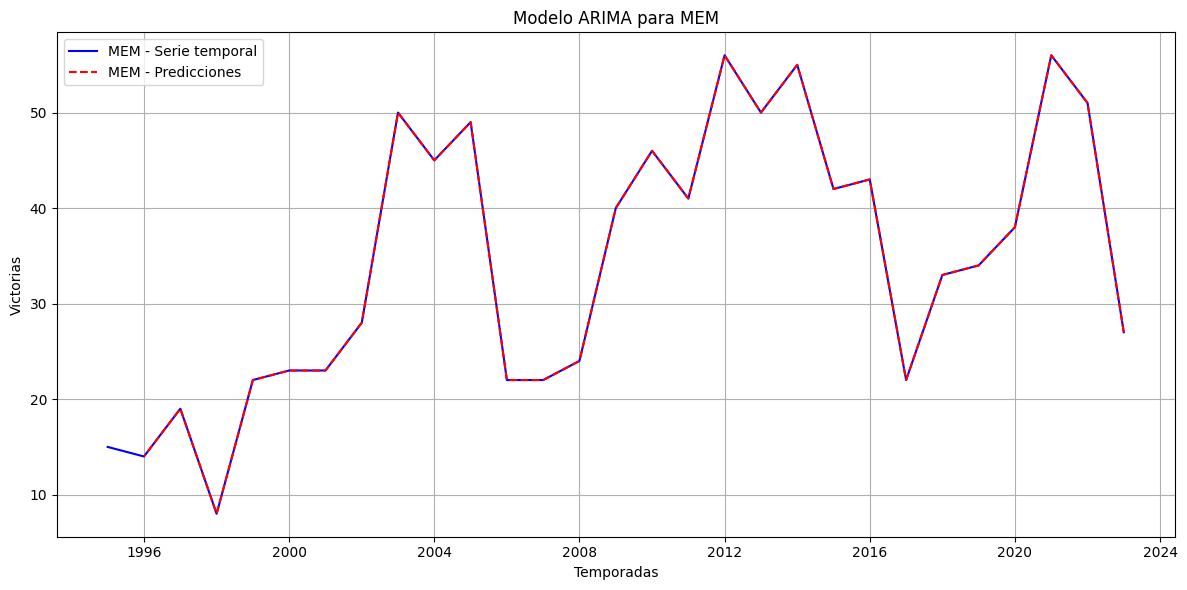

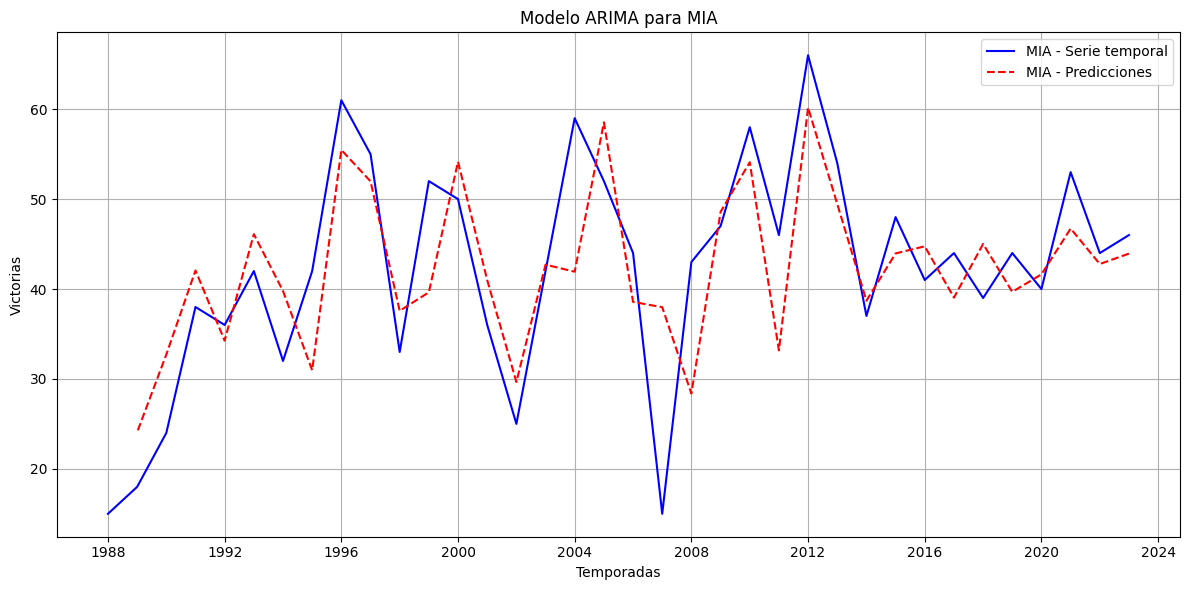

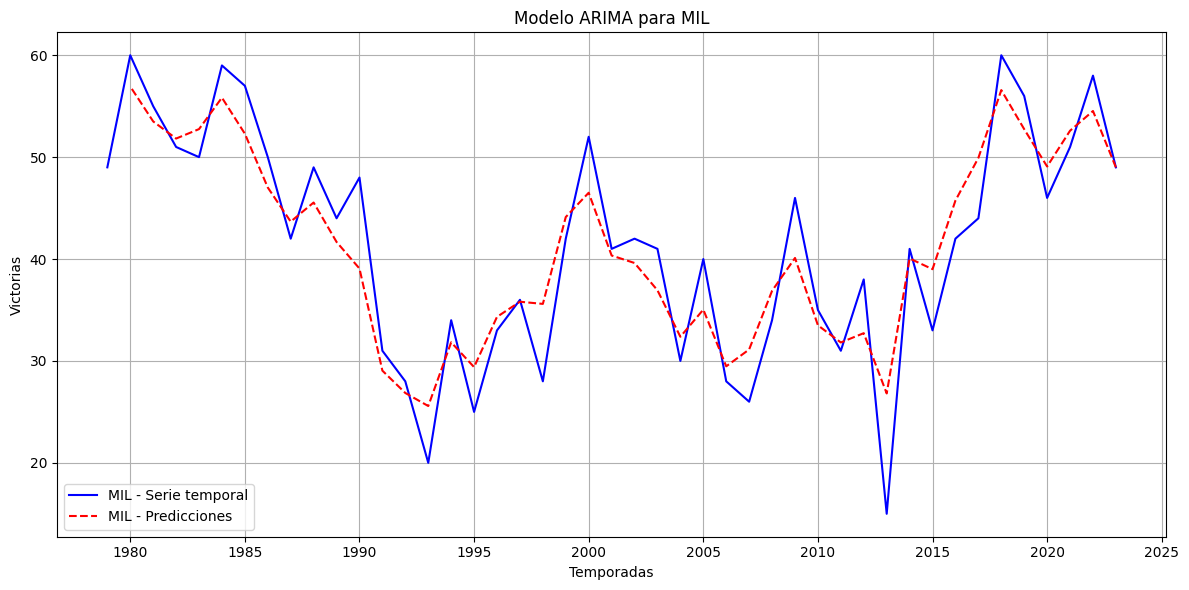

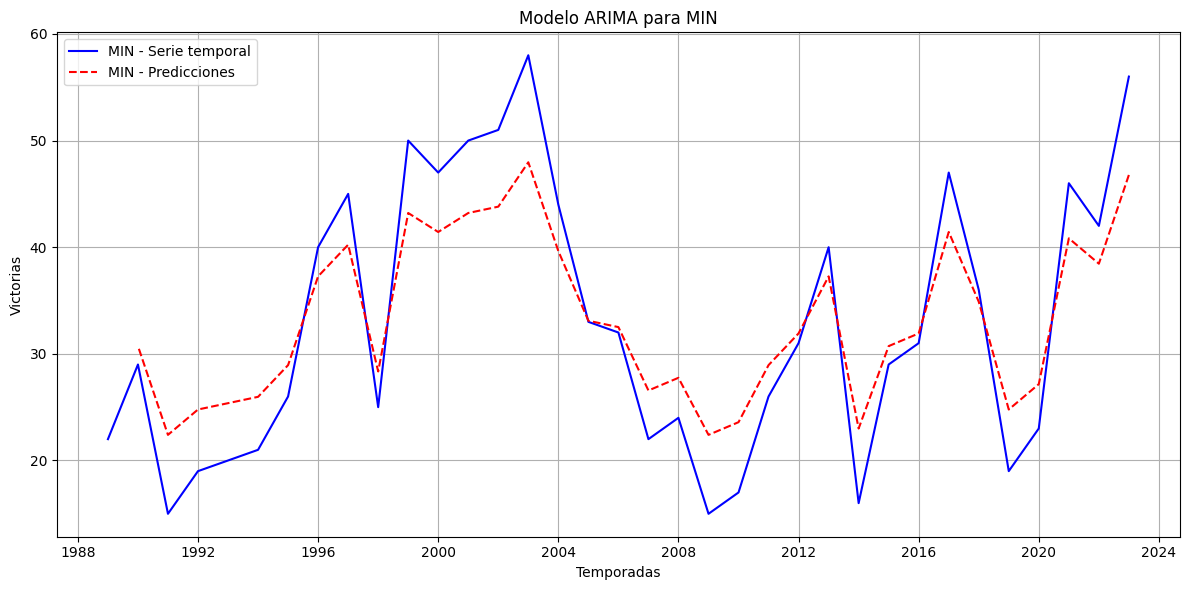

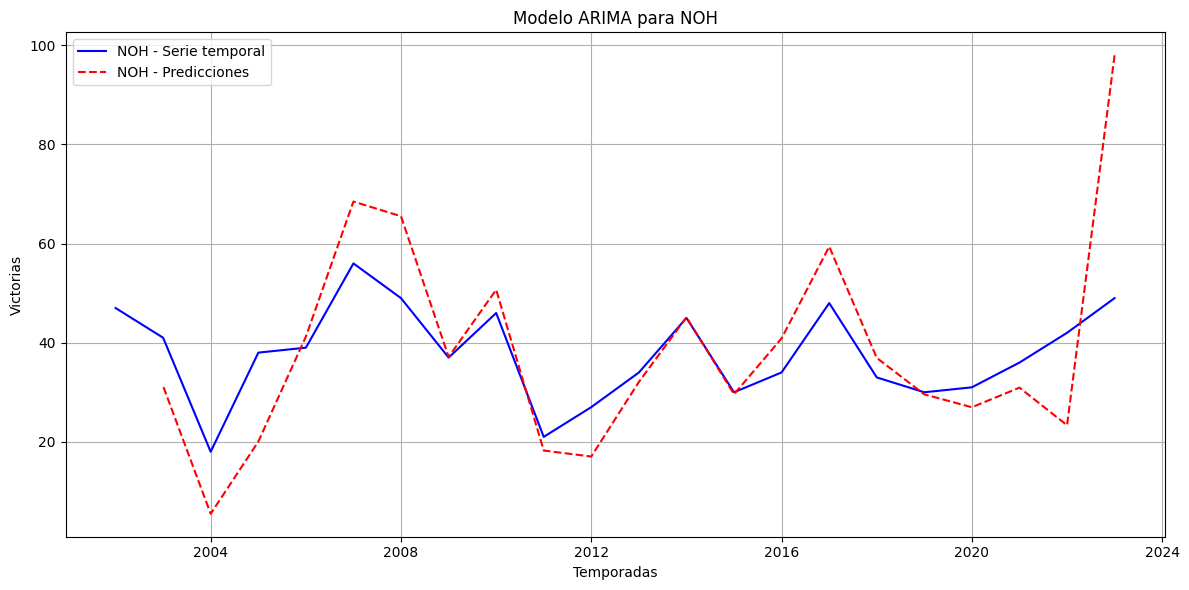

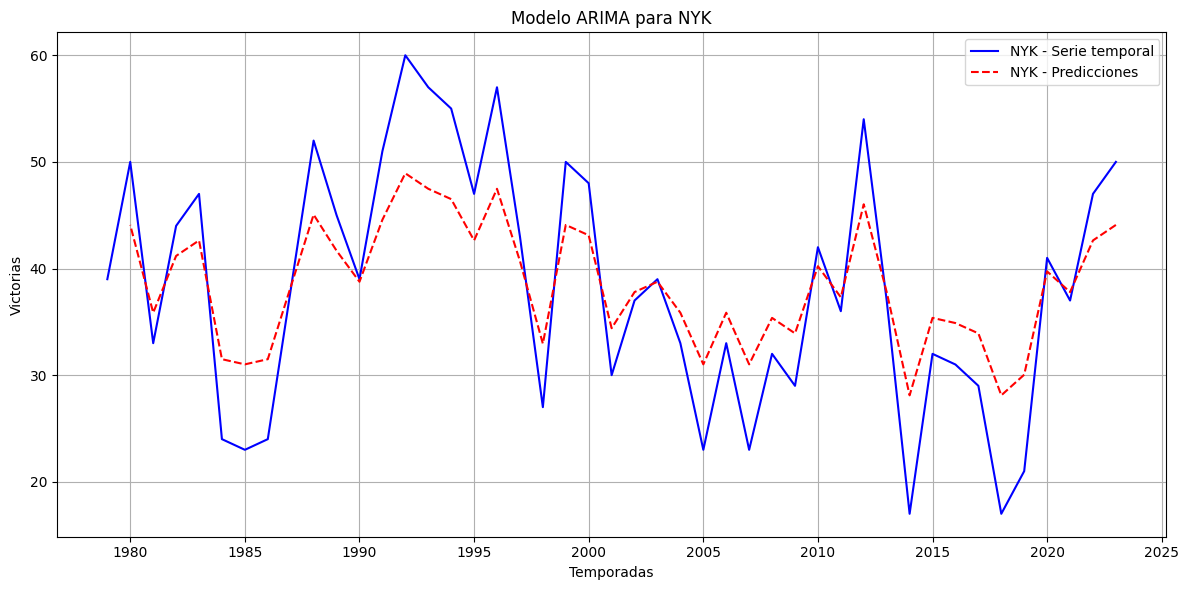

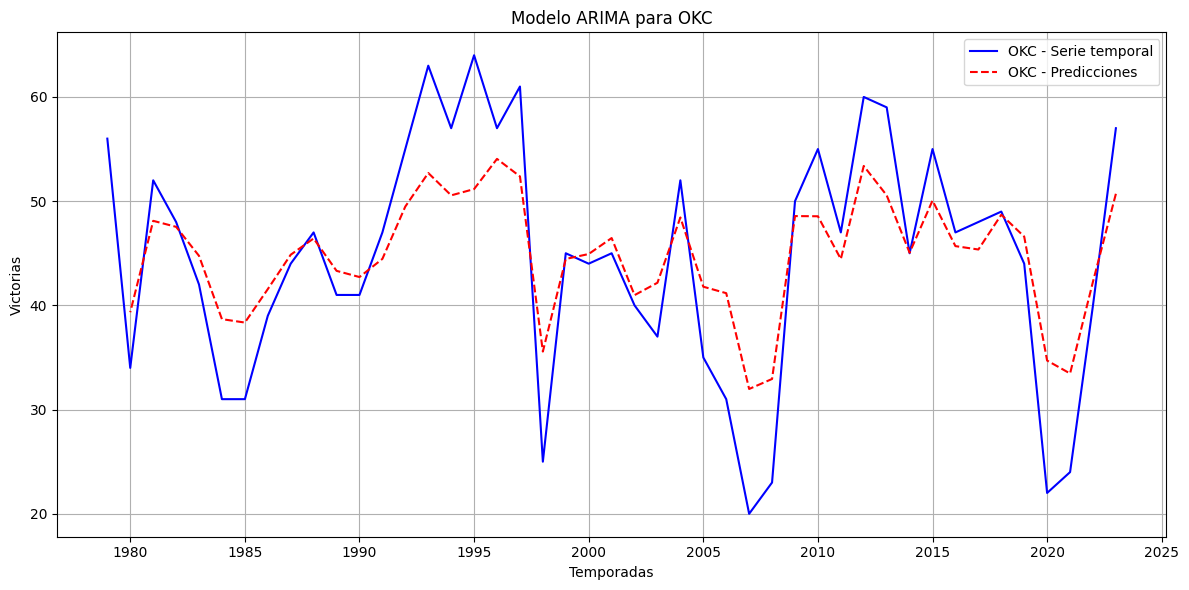

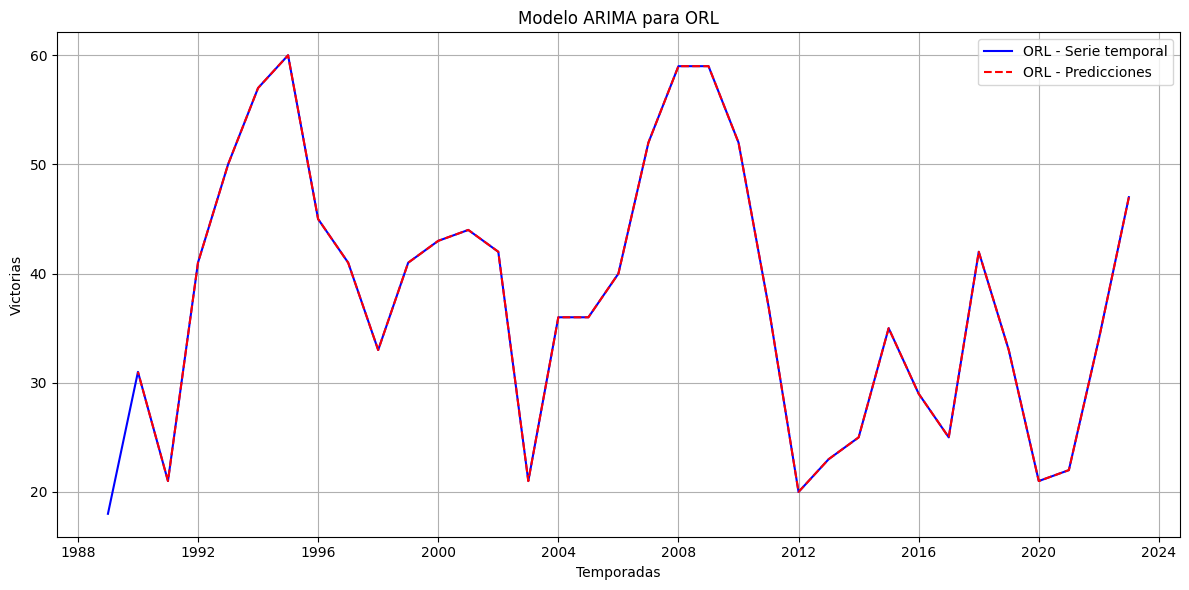

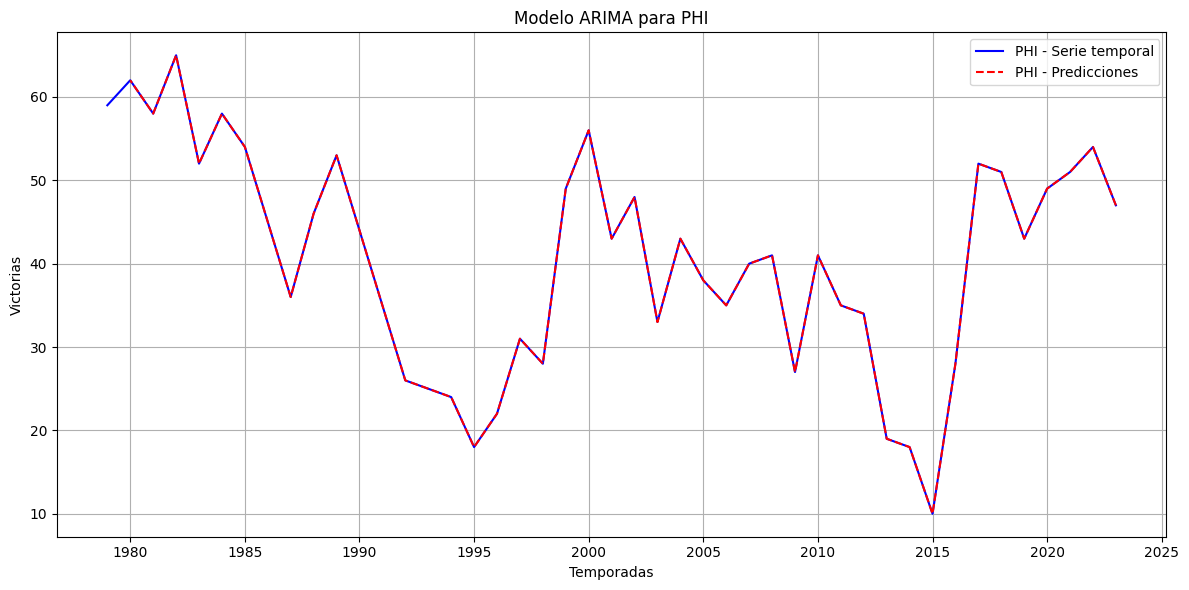

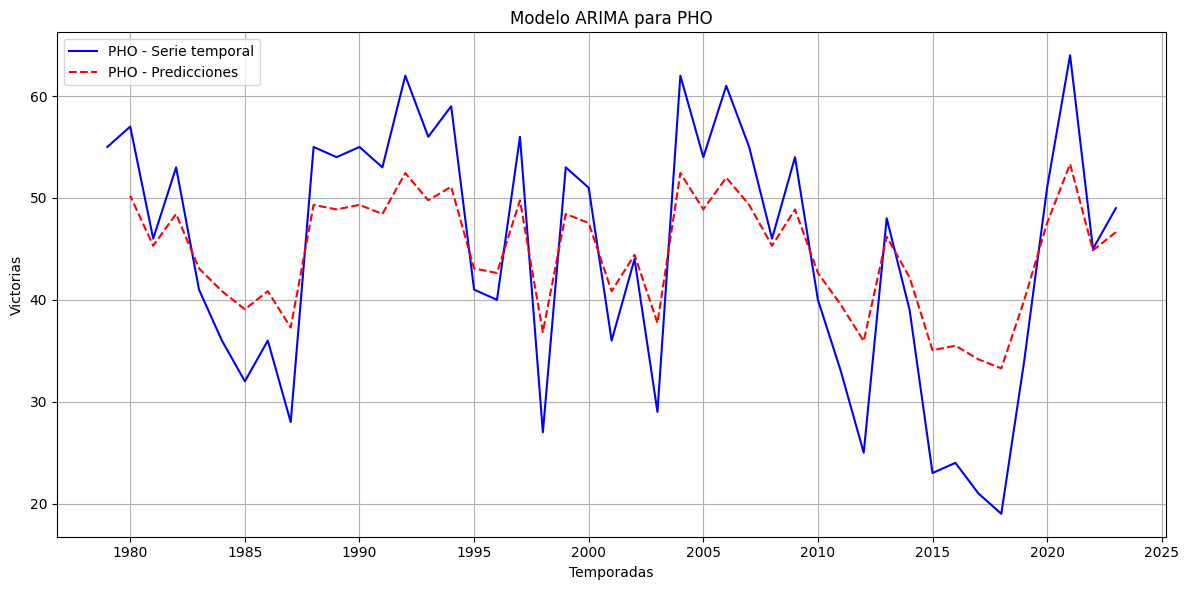

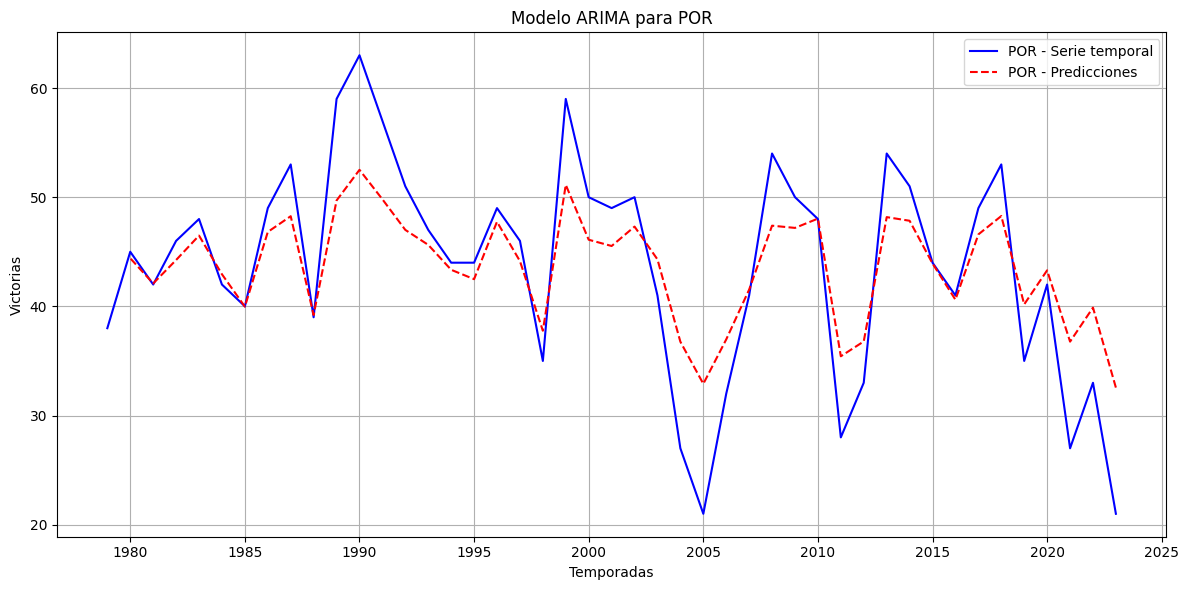

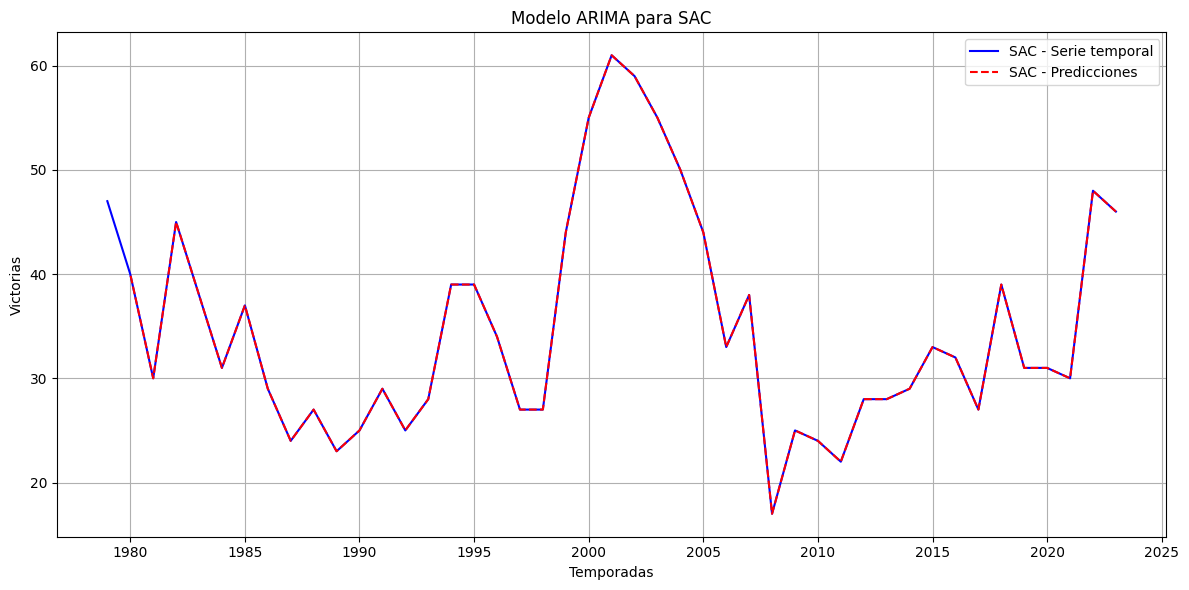

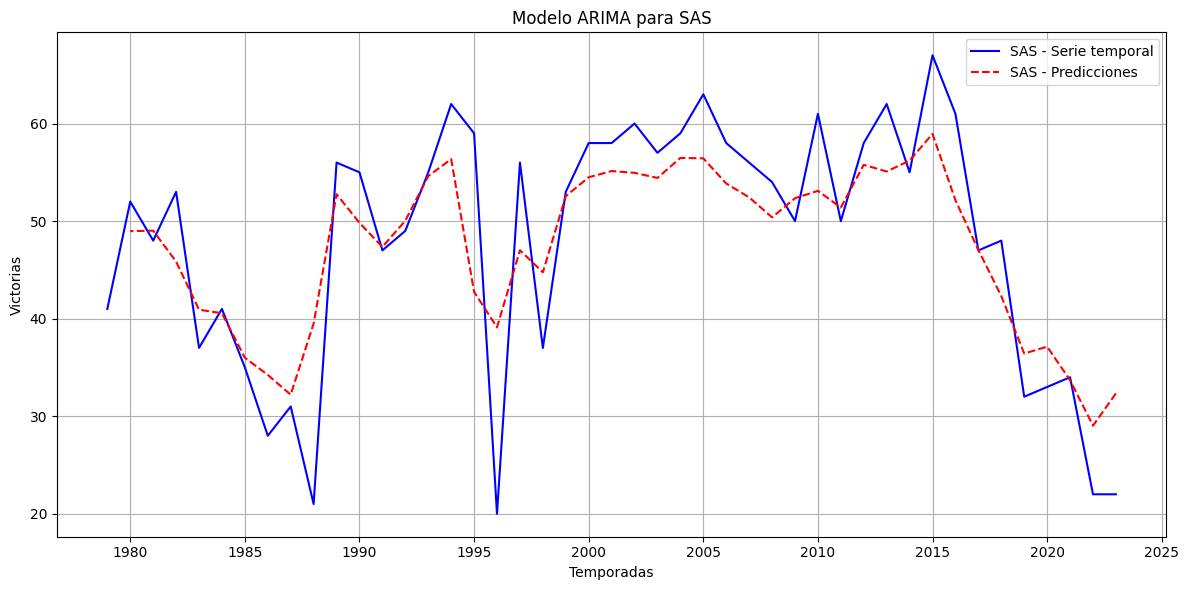

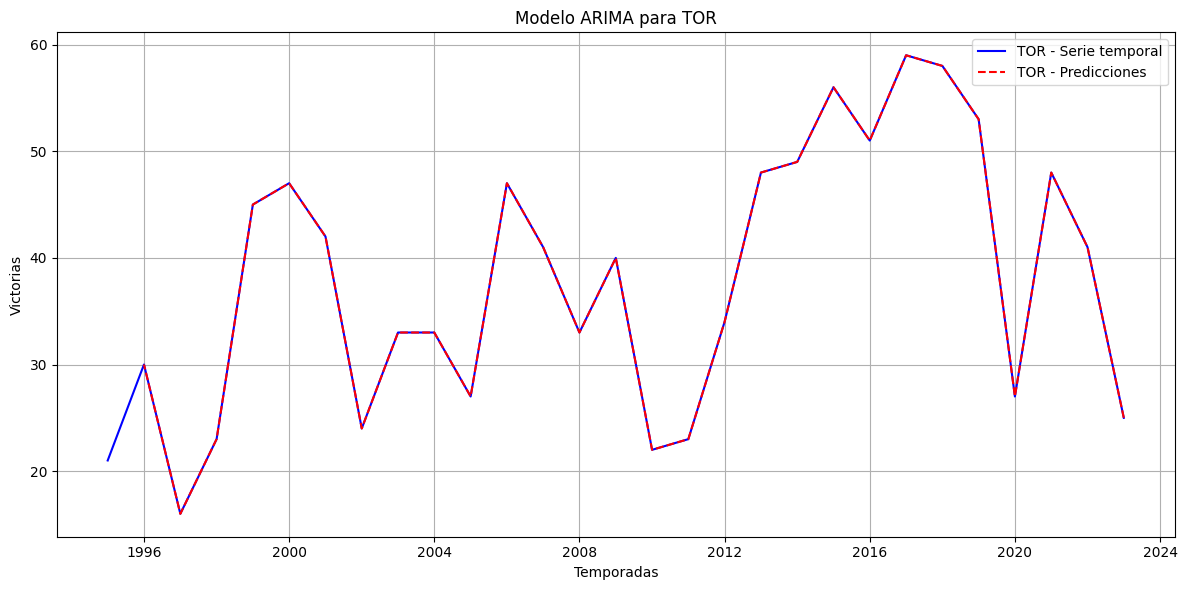

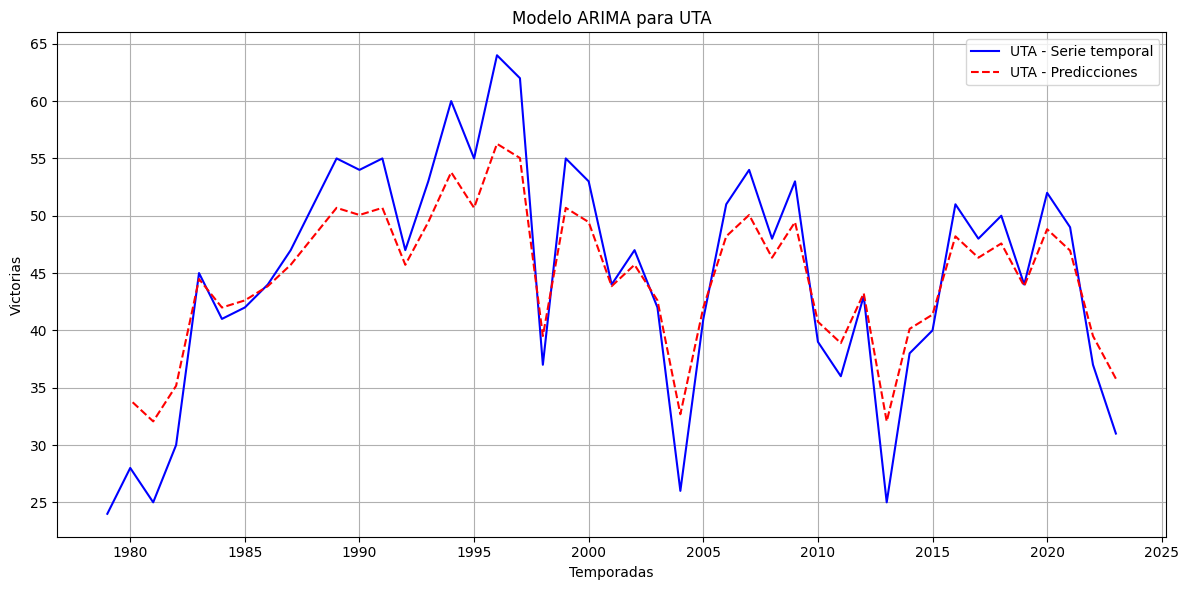

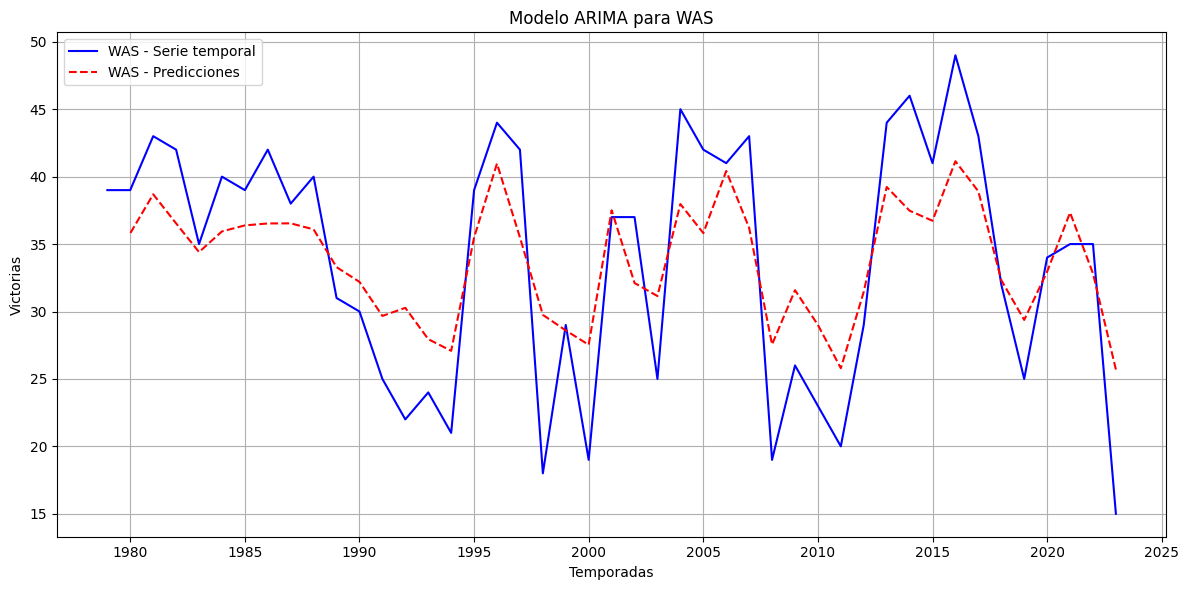

In [6]:
for equipo, model_fit in models.items():
    series = series_data[equipo]
    in_sample_preds = model_fit.predict_in_sample()
    
    #Desplazamos las predicciones a la derecha para alinearlas con las fechas
    shifted_preds = np.concatenate((in_sample_preds[1:], [np.nan]))
    preds_index = series.index
    preds_df = pd.Series(shifted_preds, index=preds_index)
    
    #Graficamos
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(series.index, series, 'b-', label=f'{equipo} - Serie temporal')  #Datos reales
    ax.plot(preds_df.index, preds_df, 'r--', label=f'{equipo} - Predicciones')  #Predicciones
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    
    plt.legend()
    plt.title(f'Modelo ARIMA para {equipo}')
    plt.xlabel('Temporadas')
    plt.ylabel('Victorias')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Predicción futura

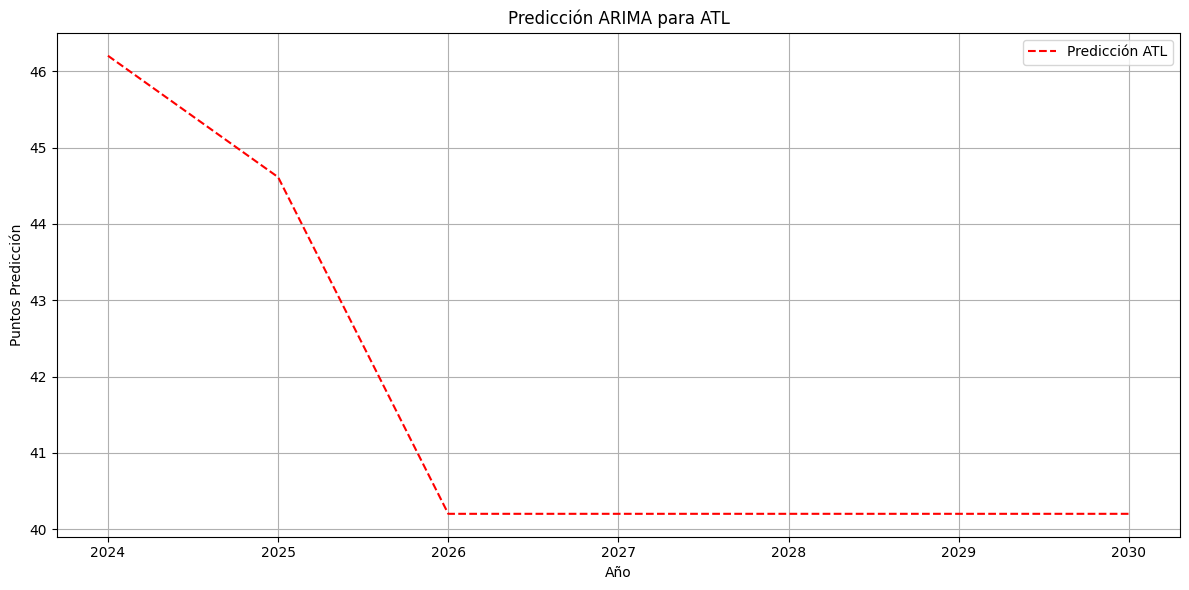

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

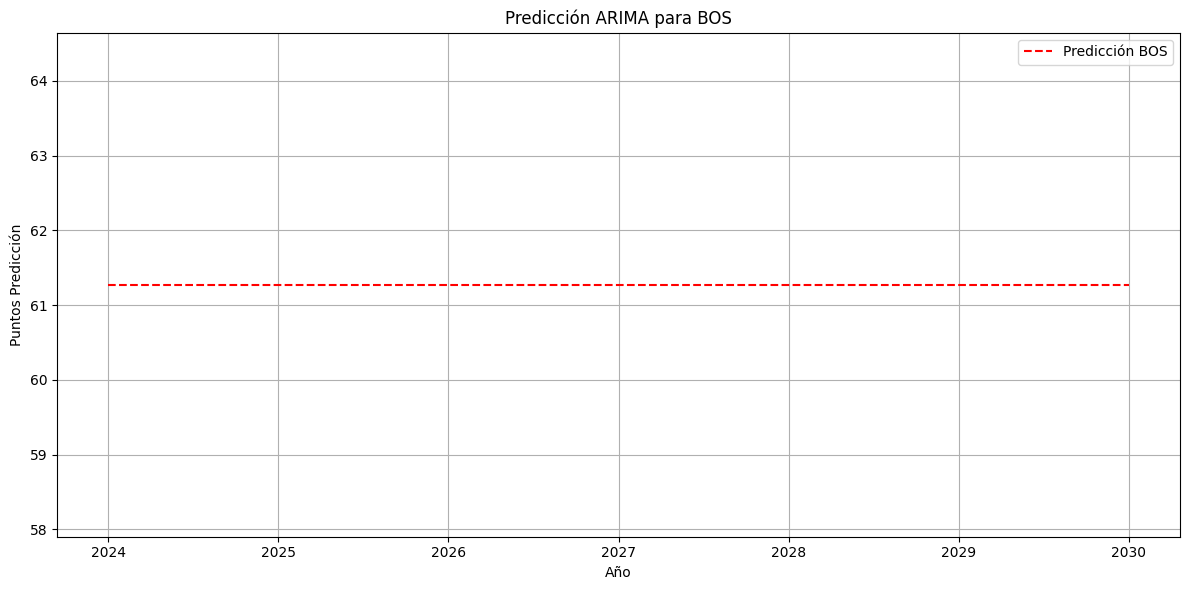

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

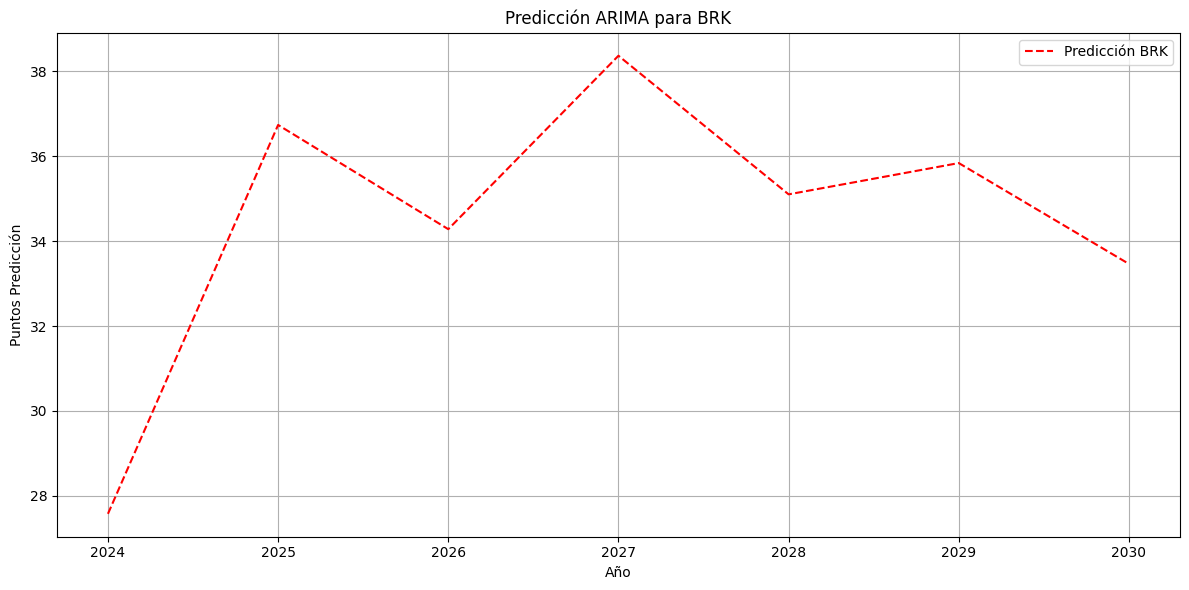

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

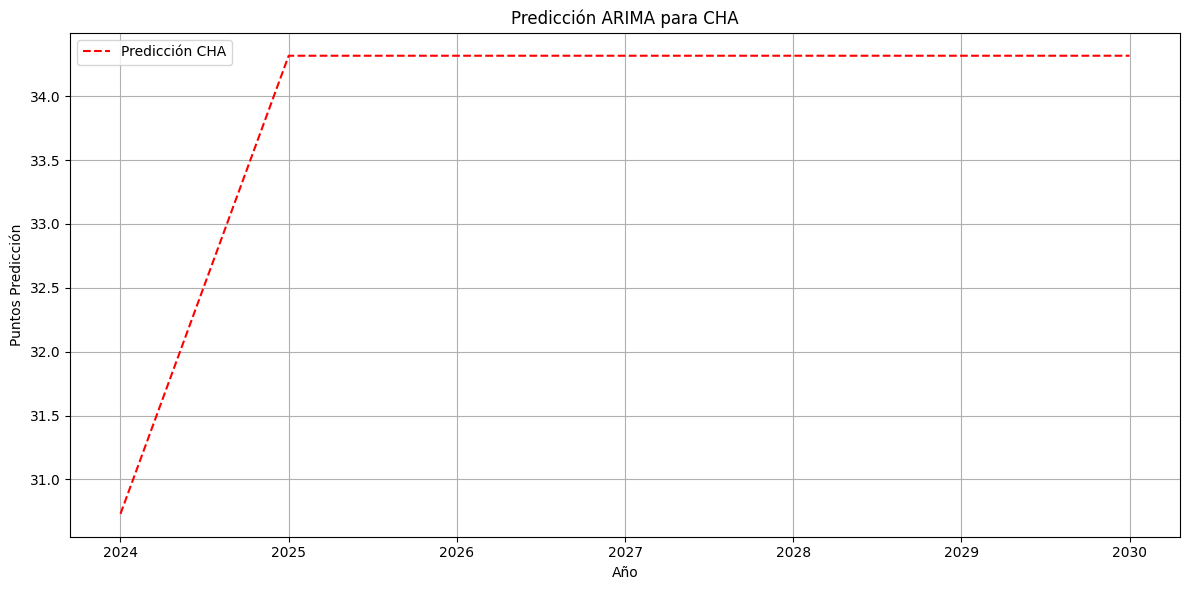

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

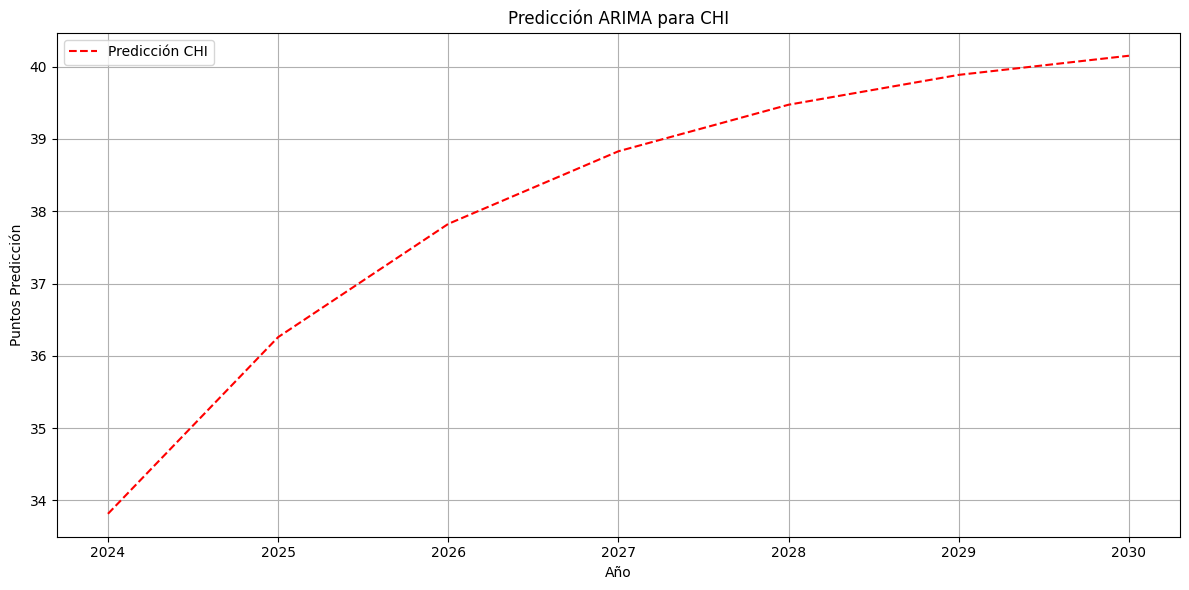

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

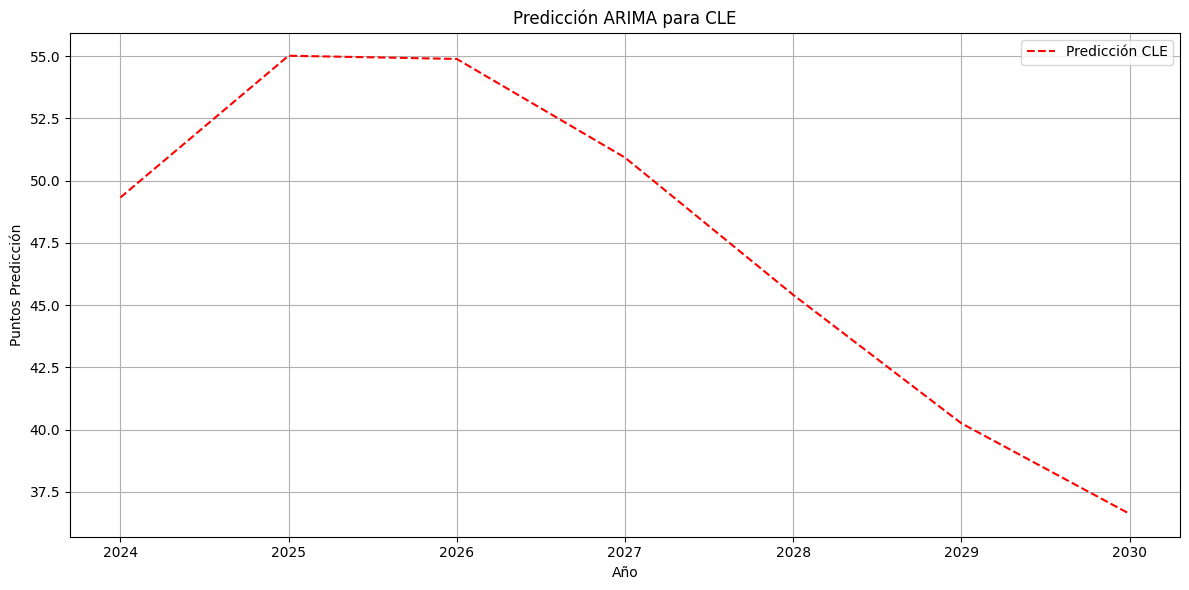

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

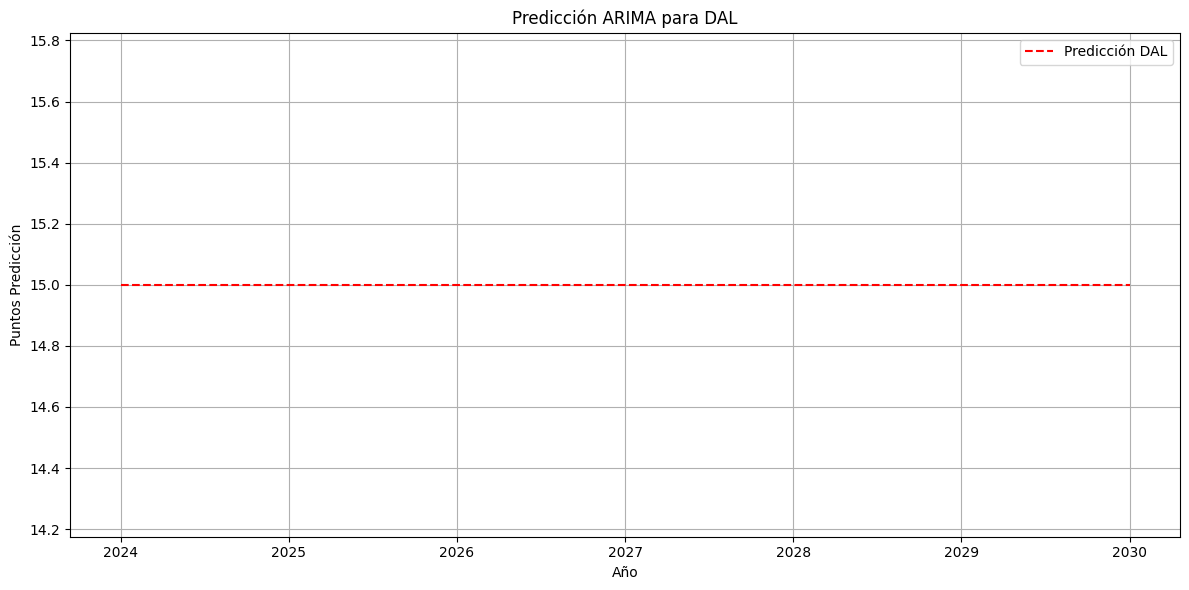

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

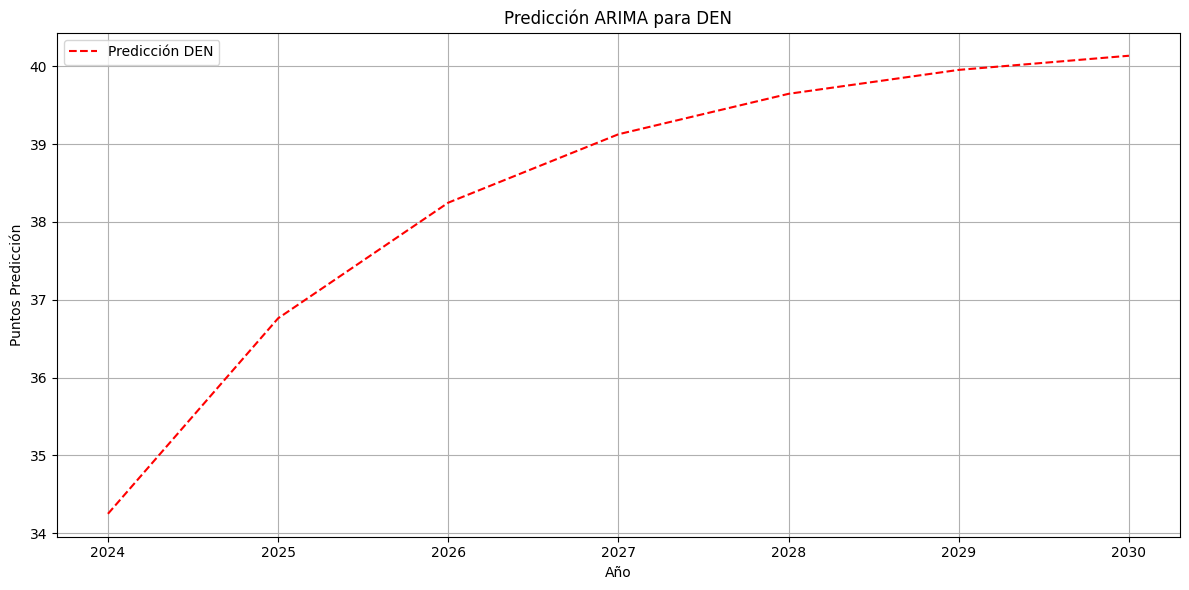

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

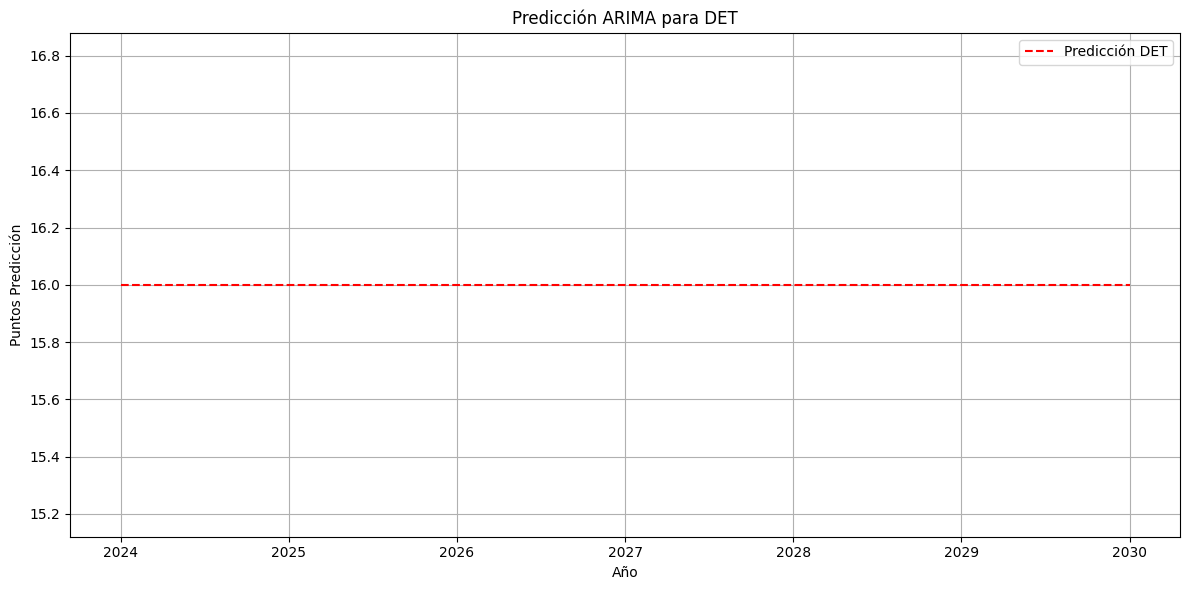

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

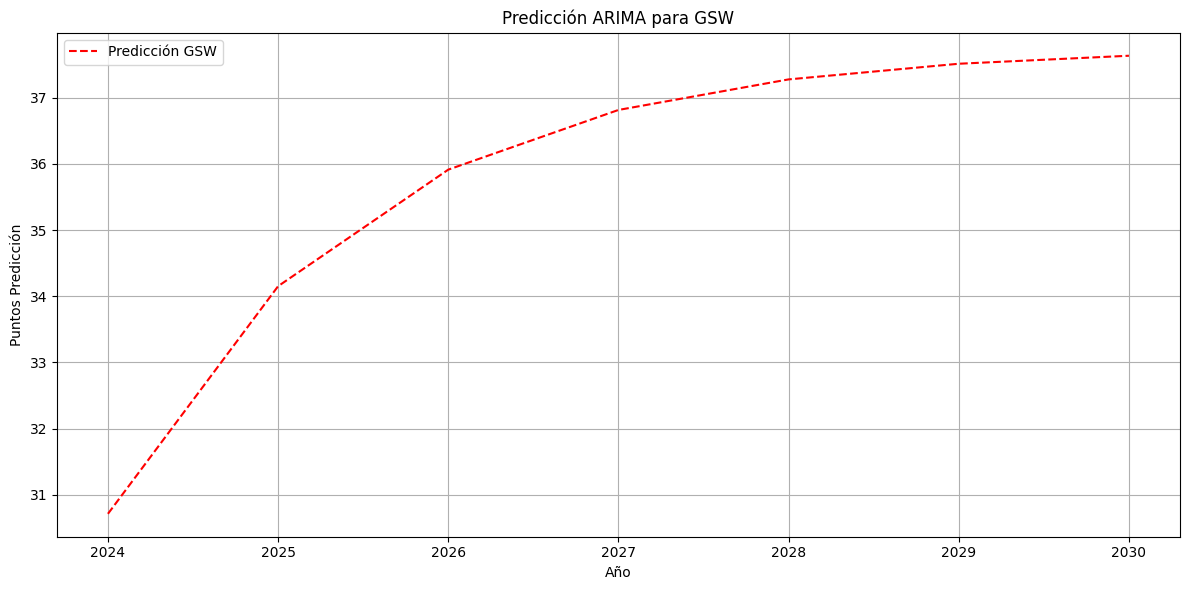

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\sfeli\Documents\Upgradehub\DA

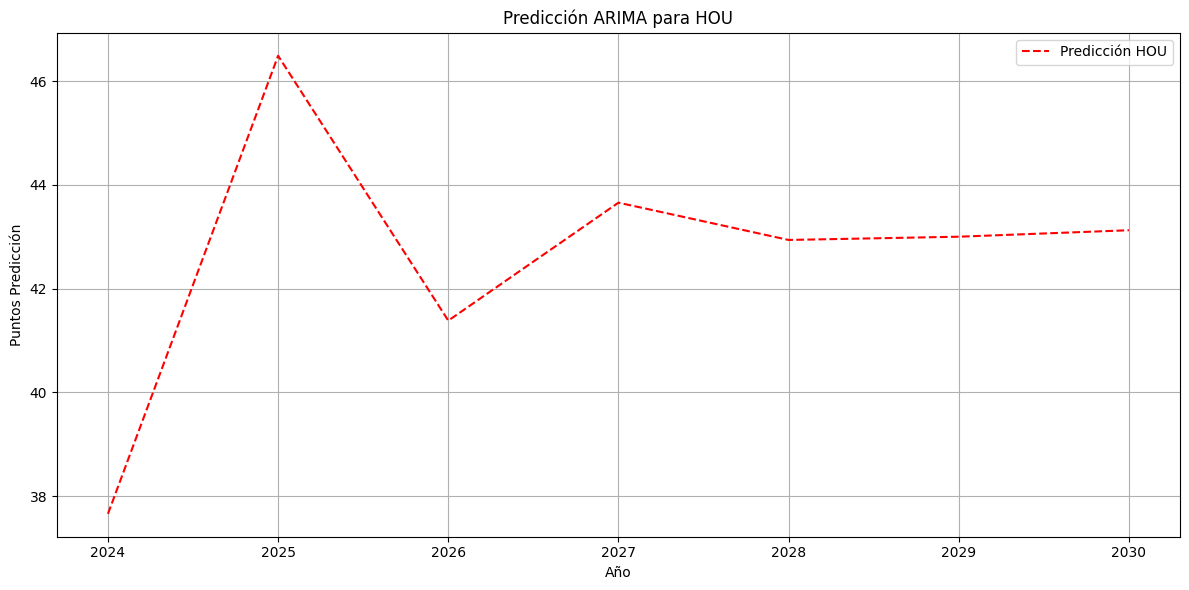

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

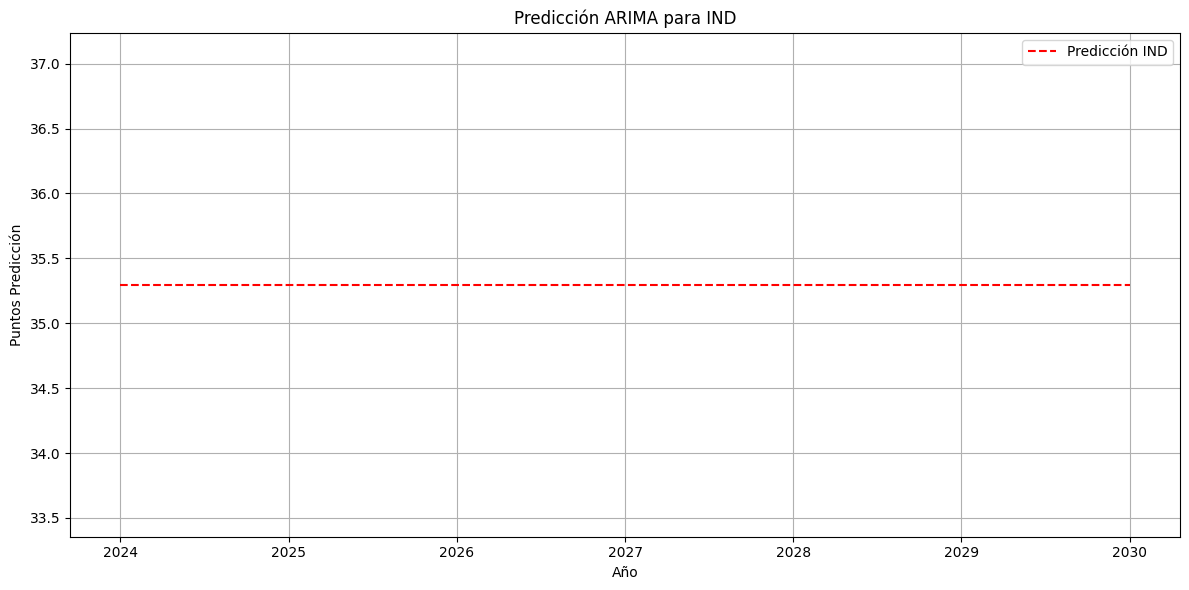

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

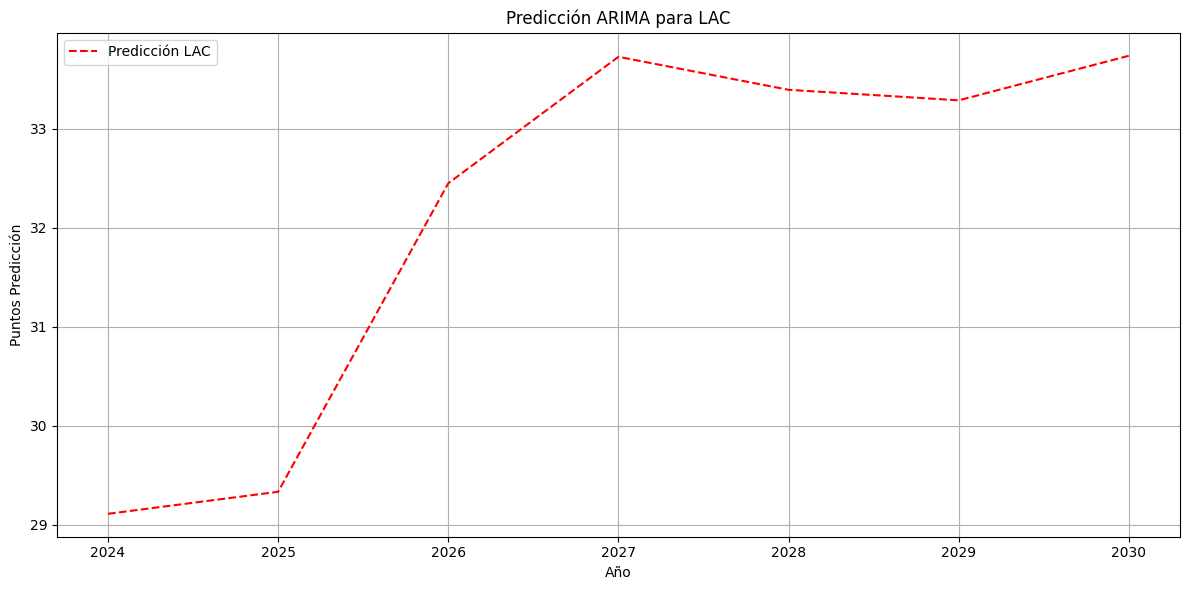

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

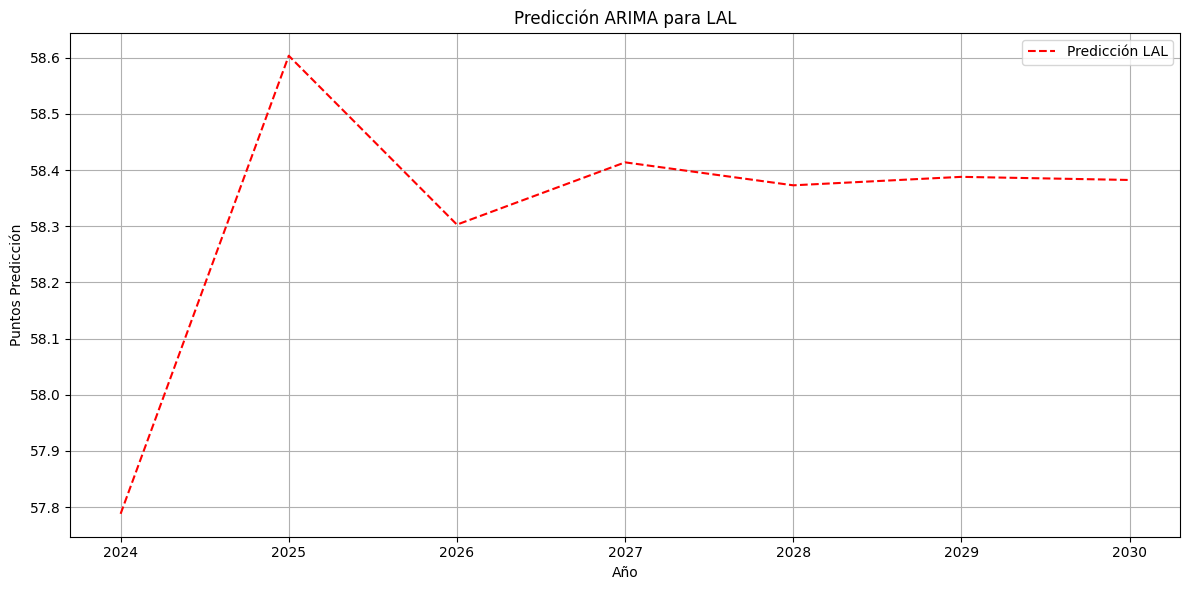

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

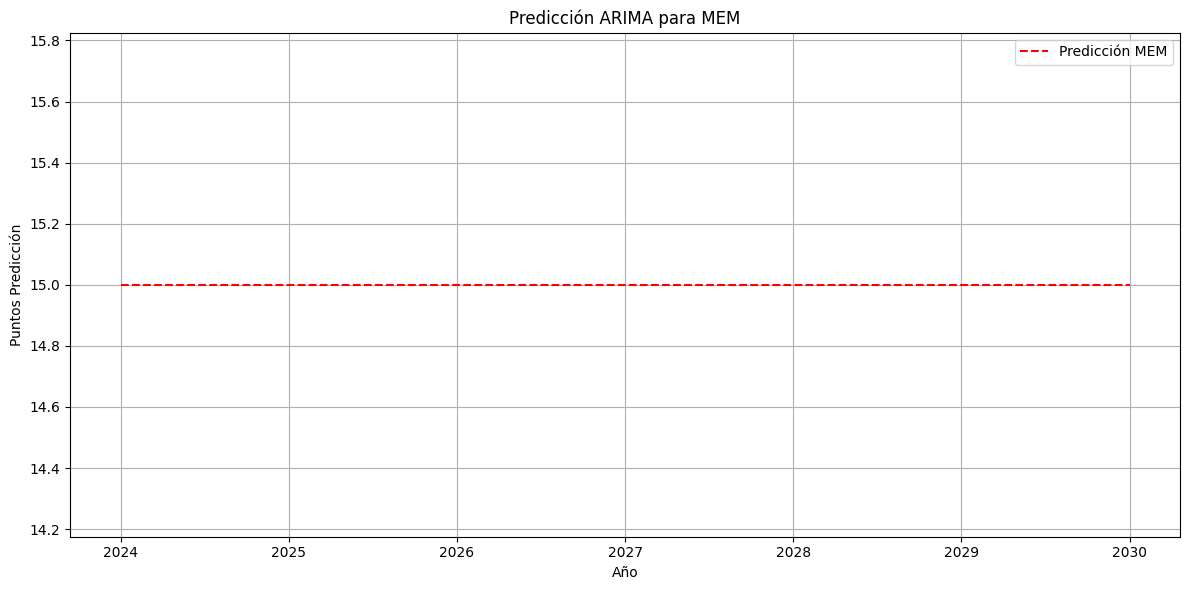

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

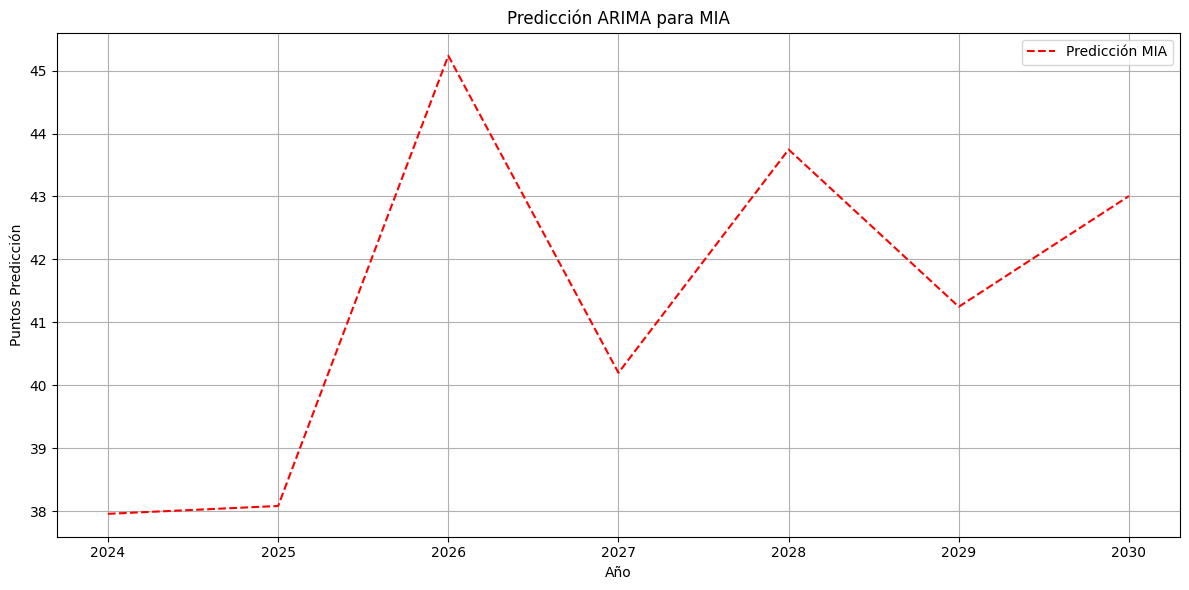

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

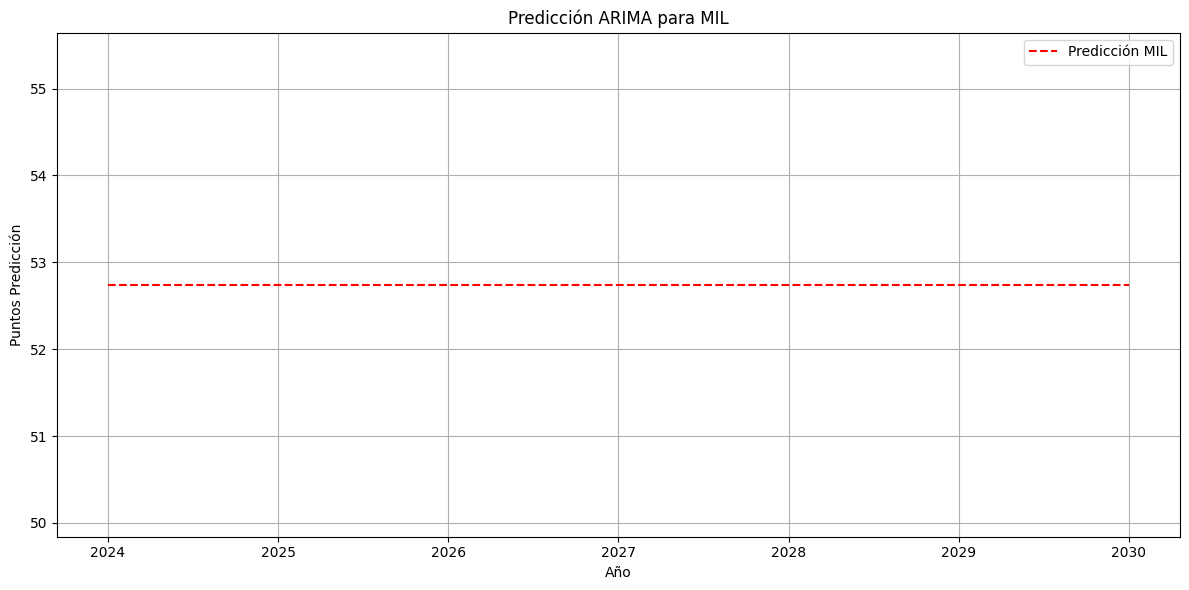

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

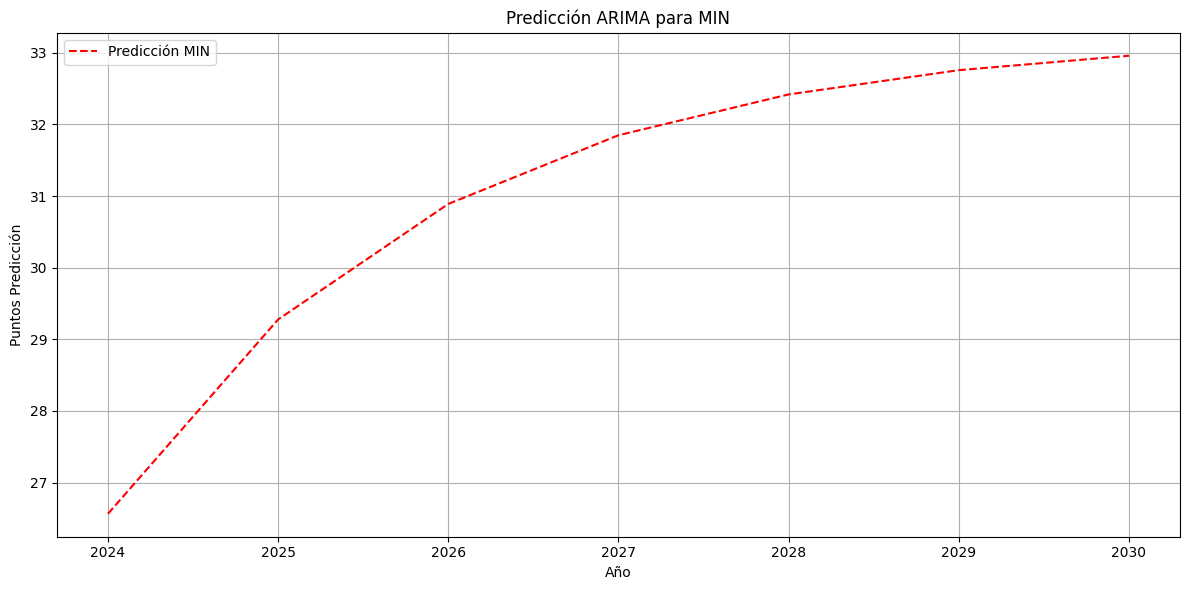

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

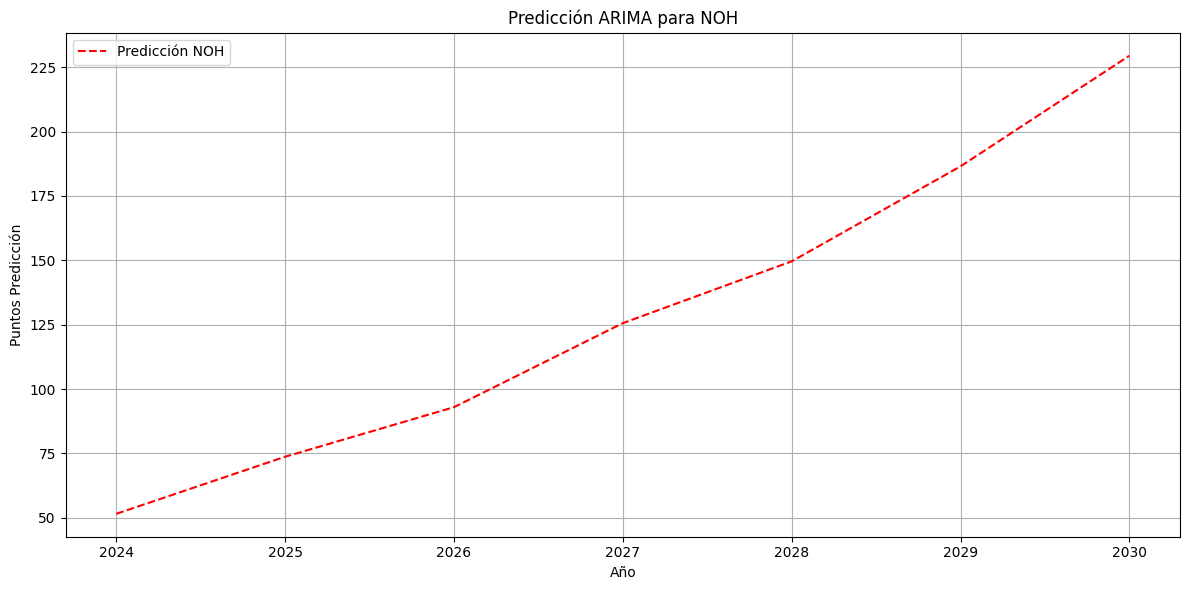

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

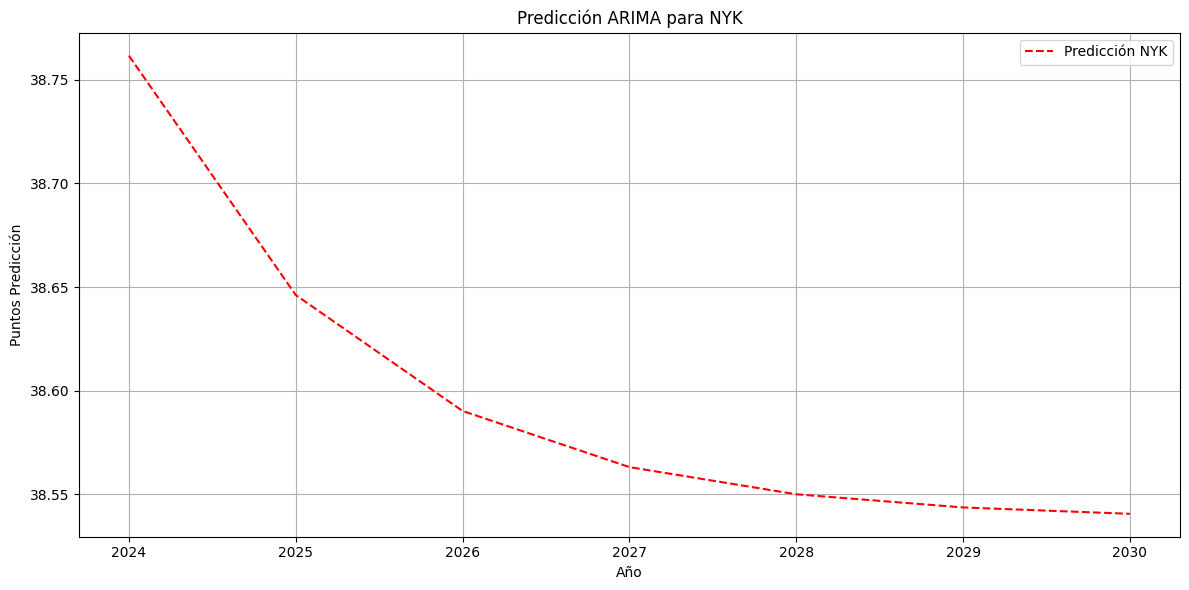

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

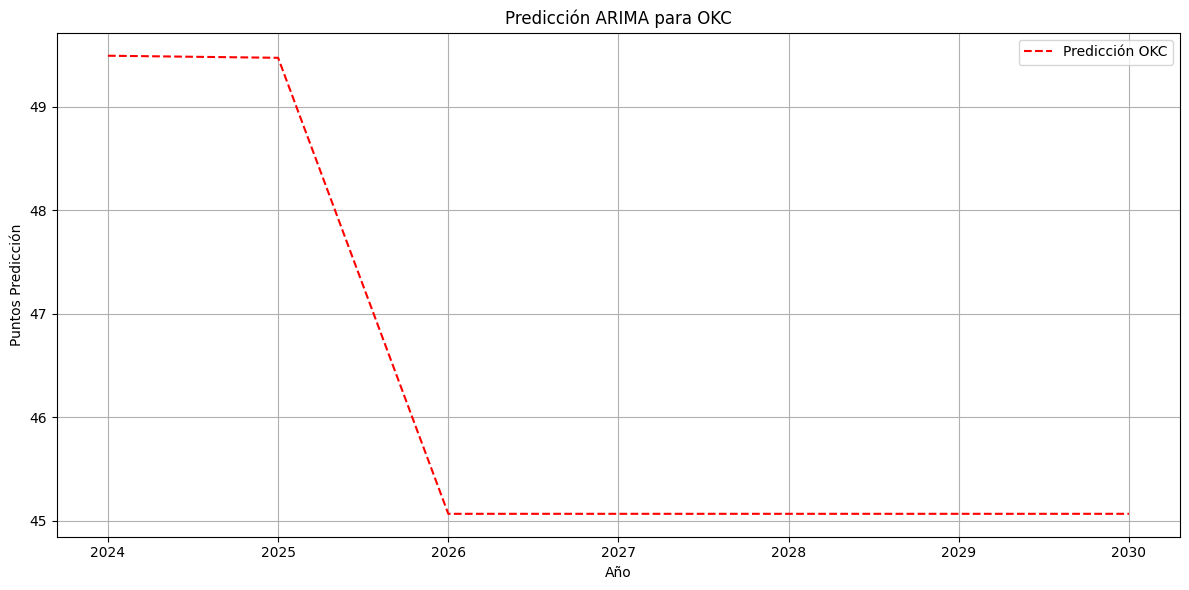

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

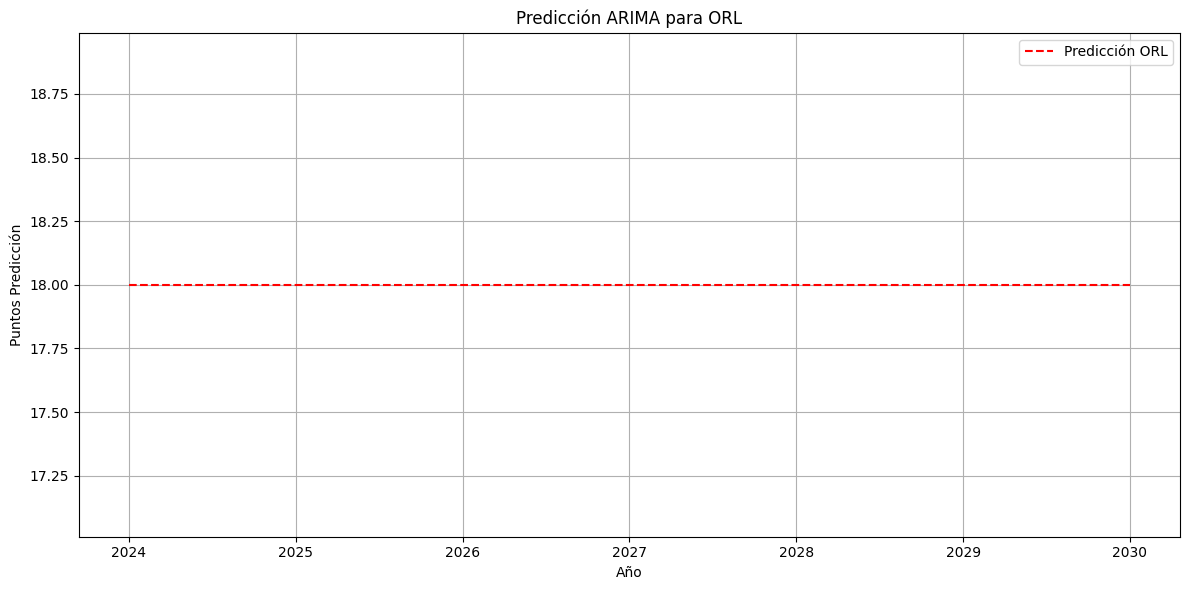

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

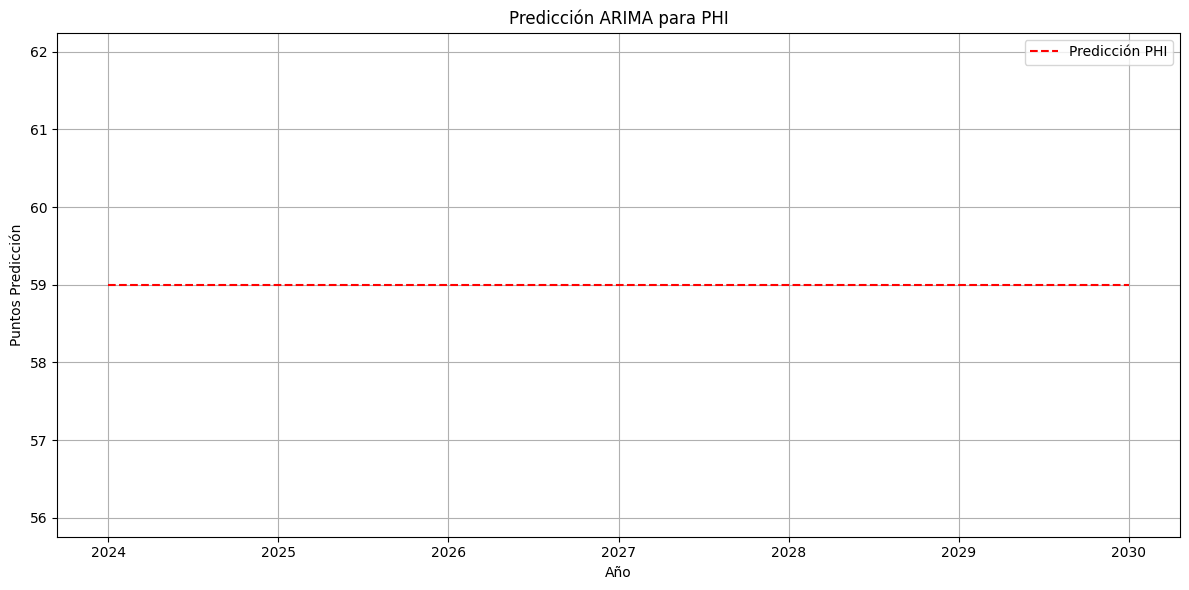

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

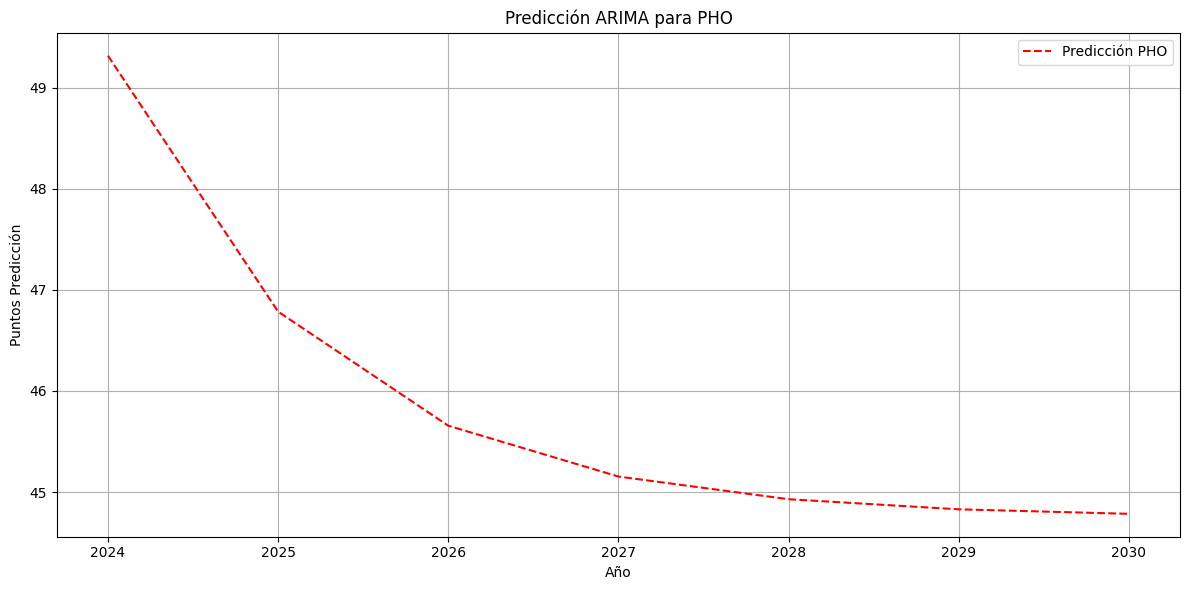

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

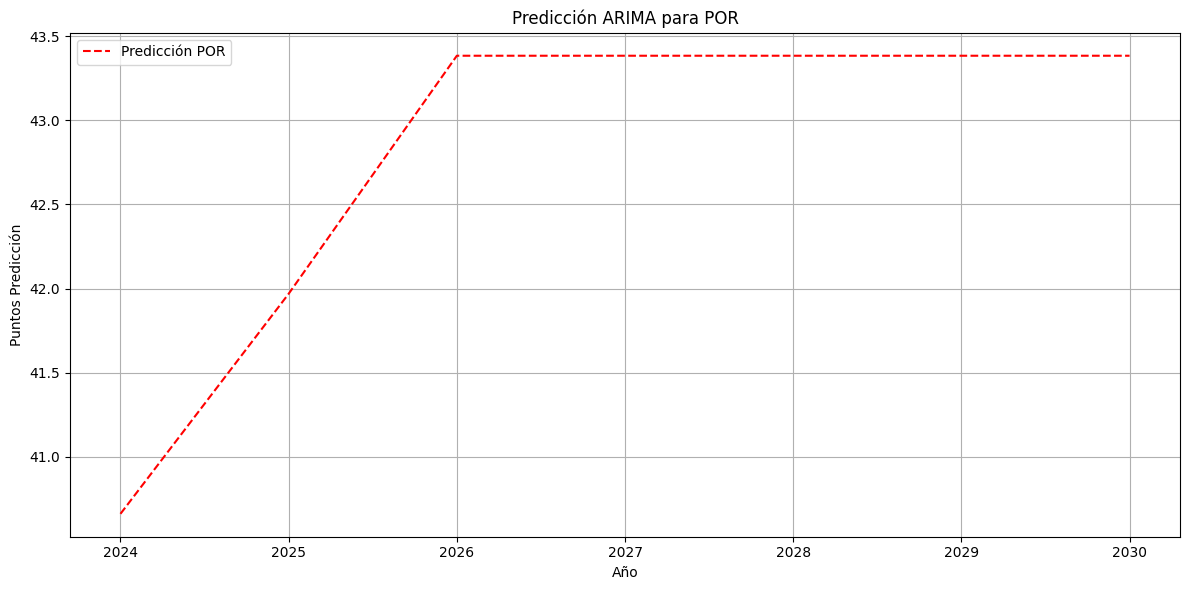

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

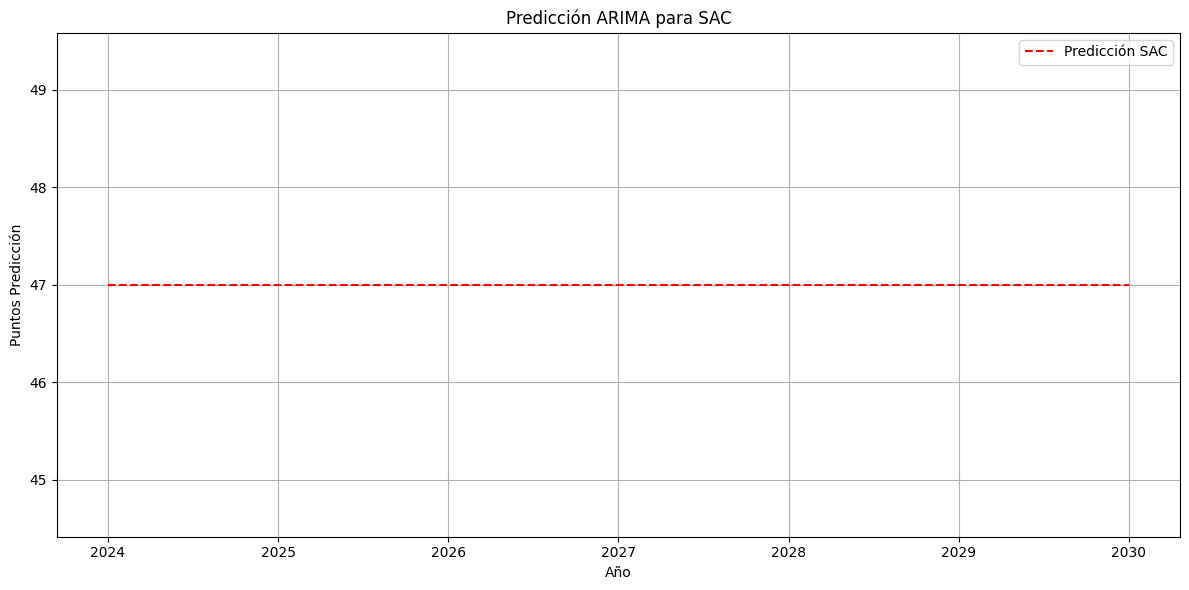

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

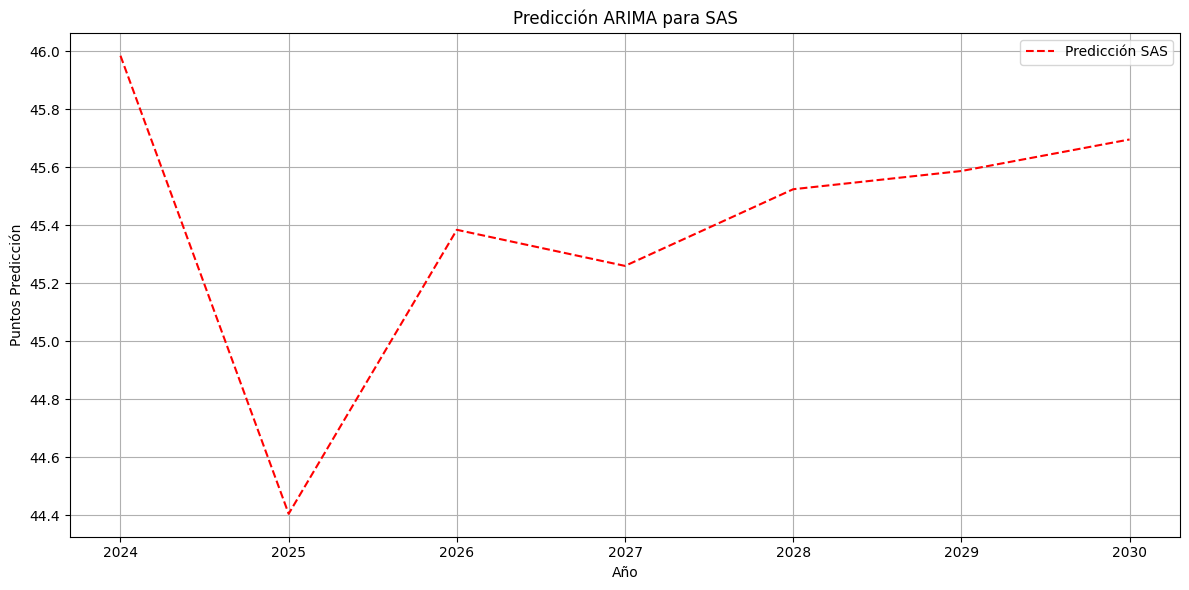

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

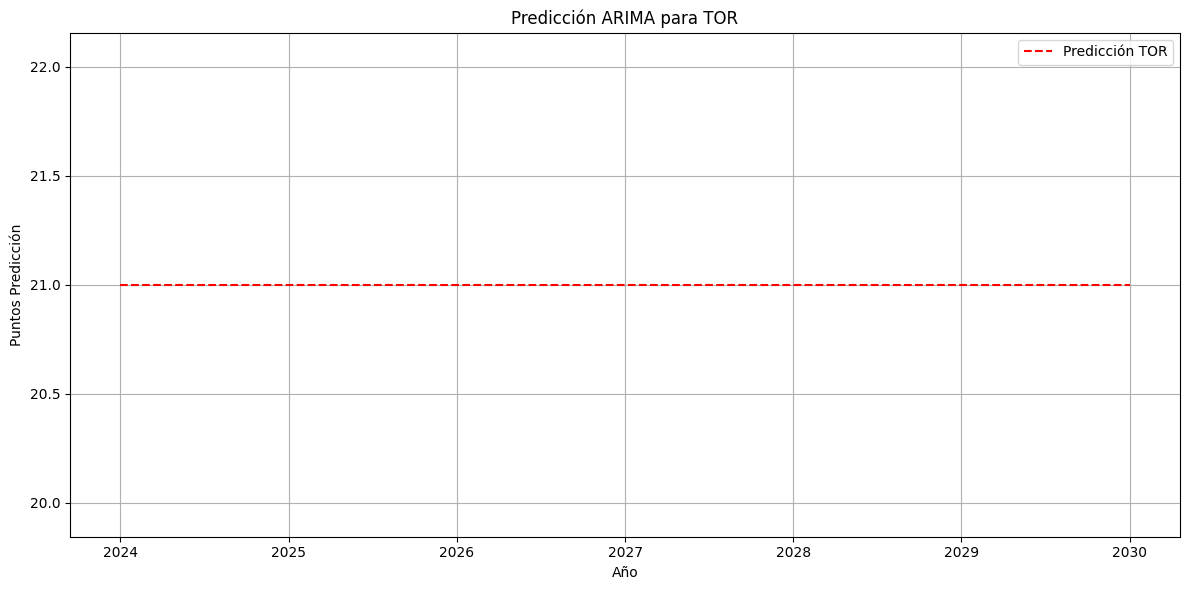

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

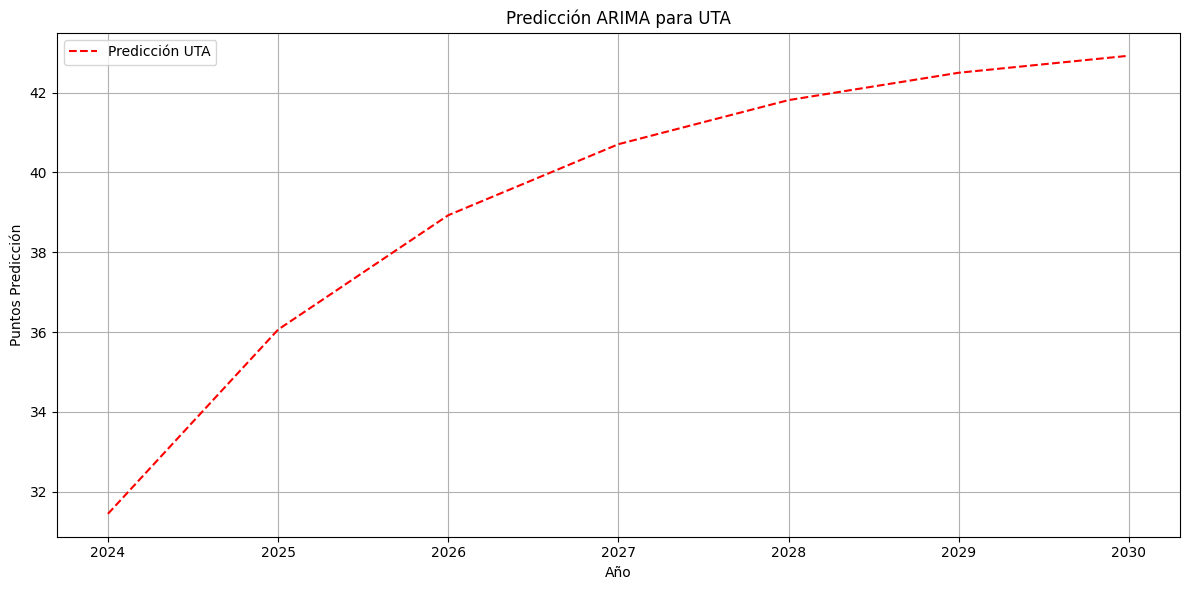

c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib

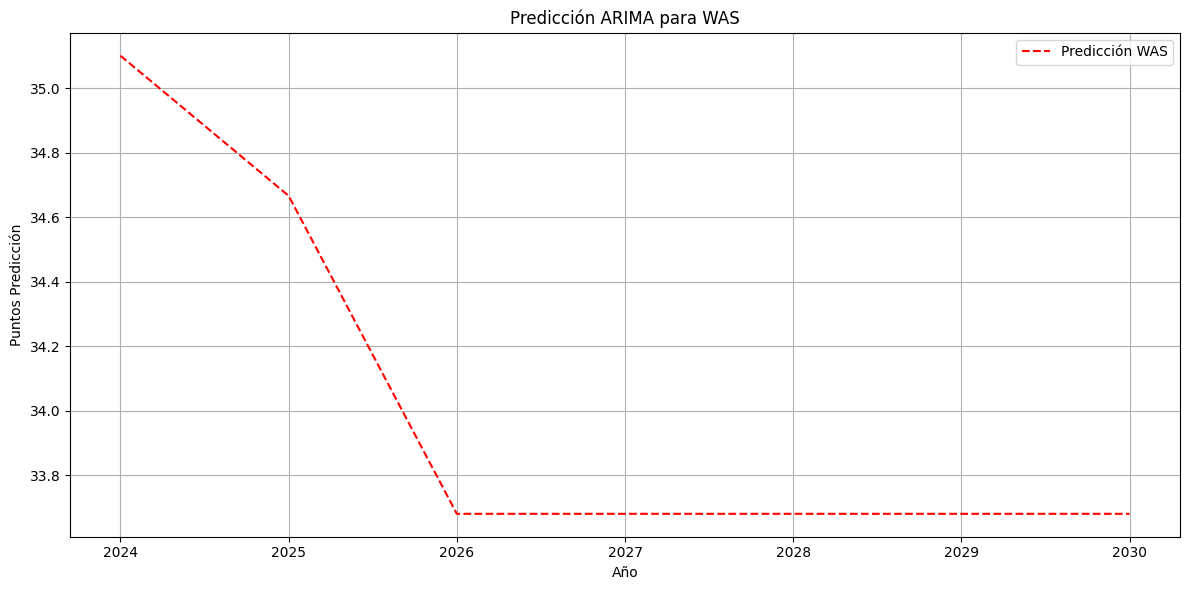

In [7]:
#Listamos los parámetros ARIMA por equipo de la fase anterior
arima_params = {
    'ATL': {'p': 0, 'd': 0, 'q': 2},
    'BOS': {'p': 0, 'd': 1, 'q': 1},
    'BRK': {'p': 3, 'd': 0, 'q': 0},
    'CHA': {'p': 0, 'd': 0, 'q': 1},
    'CHI': {'p': 1, 'd': 0, 'q': 0},
    'CLE': {'p': 2, 'd': 0, 'q': 1},
    'DAL': {'p': 0, 'd': 1, 'q': 0},
    'DEN': {'p': 1, 'd': 0, 'q': 0},
    'DET': {'p': 0, 'd': 1, 'q': 0},
    'GSW': {'p': 1, 'd': 0, 'q': 0},
    'HOU': {'p': 2, 'd': 0, 'q': 2},
    'IND': {'p': 0, 'd': 1, 'q': 1},
    'LAC': {'p': 3, 'd': 0, 'q': 0},
    'LAL': {'p': 1, 'd': 1, 'q': 0},
    'MEM': {'p': 0, 'd': 1, 'q': 0},
    'MIA': {'p': 1, 'd': 0, 'q': 2},
    'MIL': {'p': 0, 'd': 1, 'q': 1},
    'MIN': {'p': 1, 'd': 0, 'q': 0},
    'NOH': {'p': 4, 'd': 3, 'q': 0},
    'NYK': {'p': 1, 'd': 0, 'q': 0},
    'OKC': {'p': 0, 'd': 0, 'q': 2},
    'ORL': {'p': 0, 'd': 1, 'q': 0},
    'PHI': {'p': 0, 'd': 1, 'q': 0},
    'PHO': {'p': 1, 'd': 0, 'q': 0},
    'POR': {'p': 0, 'd': 0, 'q': 2},
    'SAC': {'p': 0, 'd': 1, 'q': 0},
    'SAS': {'p': 2, 'd': 0, 'q': 0},
    'TOR': {'p': 0, 'd': 1, 'q': 0},
    'UTA': {'p': 1, 'd': 0, 'q': 0},
    'WAS': {'p': 0, 'd': 0, 'q': 2}
}

#Definimos el rango de años futuros
future_years = np.arange(2024, 2031)

#Graficamos las predicciones
for team, params in arima_params.items():
    data = df[df['Team'] == team]['W']

    #Ajuste del modelo ARIMA
    model = ARIMA(data, order=(params['p'], params['d'], params['q']))
    model_fit = model.fit()

    #Predicción
    forecast = model_fit.forecast(steps=len(future_years))
    
    future_df = pd.DataFrame({
        'Año': future_years,
        'Predicción': forecast})
    
    #Graficamos
    plt.figure(figsize=(12, 6))
    plt.plot(future_df['Año'], future_df['Predicción'], 'r--', label=f'Predicción {team}')
    plt.title(f'Predicción ARIMA para {team}')
    plt.xlabel('Año')
    plt.ylabel('Puntos Predicción')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
#Parámetros ARIMA por equipo
arima_params = {
    'ATL': {'p': 0, 'd': 0, 'q': 2},
    'BOS': {'p': 0, 'd': 1, 'q': 1},
    'BRK': {'p': 3, 'd': 0, 'q': 0},
    'CHA': {'p': 0, 'd': 0, 'q': 1},
    'CHI': {'p': 1, 'd': 0, 'q': 0},
    'CLE': {'p': 2, 'd': 0, 'q': 1},
    'DAL': {'p': 0, 'd': 1, 'q': 0},
    'DEN': {'p': 1, 'd': 0, 'q': 0},
    'DET': {'p': 0, 'd': 1, 'q': 0},
    'GSW': {'p': 1, 'd': 0, 'q': 0},
    'HOU': {'p': 2, 'd': 0, 'q': 2},
    'IND': {'p': 0, 'd': 1, 'q': 1},
    'LAC': {'p': 3, 'd': 0, 'q': 0},
    'LAL': {'p': 1, 'd': 1, 'q': 0},
    'MEM': {'p': 0, 'd': 1, 'q': 0},
    'MIA': {'p': 1, 'd': 0, 'q': 2},
    'MIL': {'p': 0, 'd': 1, 'q': 1},
    'MIN': {'p': 1, 'd': 0, 'q': 0},
    'NOH': {'p': 4, 'd': 3, 'q': 0},
    'NYK': {'p': 1, 'd': 0, 'q': 0},
    'OKC': {'p': 0, 'd': 0, 'q': 2},
    'ORL': {'p': 0, 'd': 1, 'q': 0},
    'PHI': {'p': 0, 'd': 1, 'q': 0},
    'PHO': {'p': 1, 'd': 0, 'q': 0},
    'POR': {'p': 0, 'd': 0, 'q': 2},
    'SAC': {'p': 0, 'd': 1, 'q': 0},
    'SAS': {'p': 2, 'd': 0, 'q': 0},
    'TOR': {'p': 0, 'd': 1, 'q': 0},
    'UTA': {'p': 1, 'd': 0, 'q': 0},
    'WAS': {'p': 0, 'd': 0, 'q': 2}}

#Guardamos los modelos para cargarlos en Streamlit
model_path = r'C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models'
os.makedirs(model_path, exist_ok=True)

for team, params in arima_params.items():
    data = df[df['Team'] == team]['W']
    model = ARIMA(data, order=(params['p'], params['d'], params['q']))
    model_fit = model.fit()
    
    # model_file = os.path.join(model_path, f'model_{team}.pkl')
    # joblib.dump(model_fit, model_file)
    # print(f"Model for {team} saved at {model_file}")


Model for ATL saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_ATL.pkl
Model for BOS saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_BOS.pkl
Model for BRK saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_BRK.pkl
Model for CHA saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_CHA.pkl
Model for CHI saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_CHI.pkl


c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\b

Model for CLE saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_CLE.pkl
Model for DAL saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_DAL.pkl
Model for DEN saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_DEN.pkl
Model for DET saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_DET.pkl
Model for GSW saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_GSW.pkl


c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\b

Model for HOU saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_HOU.pkl
Model for IND saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_IND.pkl
Model for LAC saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_LAC.pkl
Model for LAL saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_LAL.pkl
Model for MEM saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_MEM.pkl
Model for MIA saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_MIA.pkl
Model for MIL saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_MIL.pkl
Model for MIN saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_MIN.pkl
Model for NOH saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_NOH.pkl
Model for NYK saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_NYK.pkl


c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\b

Model for OKC saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_OKC.pkl
Model for ORL saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_ORL.pkl
Model for PHI saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_PHI.pkl
Model for PHO saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_PHO.pkl
Model for POR saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_POR.pkl
Model for SAC saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_SAC.pkl


c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\b

Model for SAS saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_SAS.pkl
Model for TOR saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_TOR.pkl
Model for UTA saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_UTA.pkl
Model for WAS saved at C:\Users\sfeli\Documents\Upgradehub\DATA\NBA\ARIMA_models\model_WAS.pkl


c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sfeli\Documents\Upgradehub\DATA\entorno\Lib\site-packages\statsmodels\tsa\b